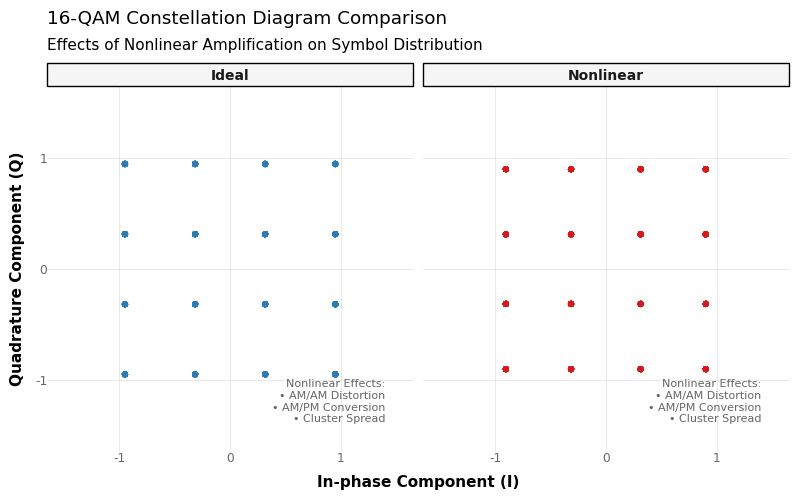

In [ ]:
# Re-import necessary libraries after execution state reset
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_point, facet_wrap, coord_fixed, scale_color_manual, theme_minimal, theme, element_line, element_blank, element_rect, element_text, labs, annotate

# Generate 16-QAM symbols
n_symbols = 1000
symbols = np.array([-3, -1, 1, 3]) / np.sqrt(10)  # Normalized constellation
i = np.random.choice(symbols, n_symbols)
q = np.random.choice(symbols, n_symbols)

# Simulate nonlinear amplification using Rapp model
def rapp_model(x, p=2, v_sat=2):
    return x / (1 + (np.abs(x)/v_sat)**p)**(1/(2*p))

i_distorted = rapp_model(i)
q_distorted = rapp_model(q)

# Create DataFrames
df_ideal = pd.DataFrame({'I': i, 'Q': q, 'Condition': 'Ideal'})
df_distorted = pd.DataFrame({'I': i_distorted, 'Q': q_distorted, 'Condition': 'Nonlinear'})
df = pd.concat([df_ideal, df_distorted])

# Create advanced ggplot
plot = (ggplot(df, aes(x='I', y='Q', color='Condition'))
        + geom_point(alpha=0.7, size=2.5, stroke=0)
        + facet_wrap('~Condition', nrow=1)
        + coord_fixed(ratio=1, xlim=(-1.5,1.5), ylim=(-1.5,1.5))
        + scale_color_manual(values=["#2c7bb6", "#d7191c"])
        + theme_minimal()
        + theme(
            figure_size=(10, 5),
            panel_grid_major=element_line(color='#e0e0e0', size=0.5),
            panel_grid_minor=element_blank(),
            strip_background=element_rect(fill='#f5f5f5'),
            strip_text=element_text(weight='bold', size=10),
            legend_position='none',
            axis_text=element_text(color='#666666'),
            axis_title=element_text(weight='bold')
        )
        + labs(
            title='16-QAM Constellation Diagram Comparison',
            subtitle='Effects of Nonlinear Amplification on Symbol Distribution',
            x='In-phase Component (I)',
            y='Quadrature Component (Q)'
        )
        + annotate(
            'text',
            x=1.4, y=-1.4,
            label='Nonlinear Effects:\n• AM/AM Distortion\n• AM/PM Conversion\n• Cluster Spread',
            ha='right',
            va='bottom',
            size=8,
            color='#666666'
        )
)

# Display the plot
plot.draw()


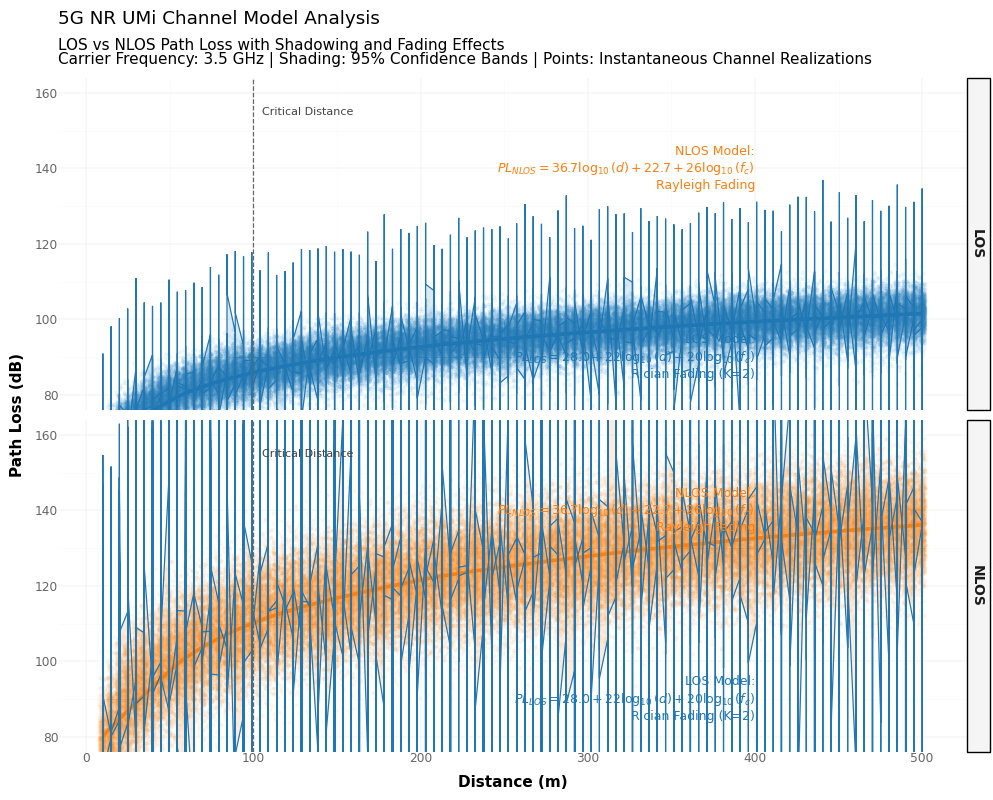

In [ ]:
import numpy as np
import pandas as pd
from plotnine import *
from plotnine.themes import theme_minimal
from scipy.stats import rice, rayleigh

# Channel model parameters
fc = 3.5e9  # 3.5 GHz carrier frequency
distances = np.linspace(10, 500, 100)  # 10-500 meters
n_samples = 1000

# 5G NR UMi path loss models (3GPP TR 38.901)
def path_loss_los(d):
    return 28.0 + 22*np.log10(d) + 20*np.log10(fc/1e9)

def path_loss_nlos(d):
    return 36.7*np.log10(d) + 22.7 + 26*np.log10(fc/1e9)

# Generate data
data = []
for d in distances:
    # LOS Components
    pl_los = path_loss_los(d)
    shadowing_los = np.random.normal(0, 3, n_samples)  # 3dB std
    fading_los = rice.rvs(2, scale=1, size=n_samples)  # Rician fading

    # NLOS Components
    pl_nlos = path_loss_nlos(d)
    shadowing_nlos = np.random.normal(0, 8, n_samples)  # 8dB std
    fading_nlos = rayleigh.rvs(scale=1, size=n_samples)  # Rayleigh fading

    # Create dataframe
    data.extend([
        {'Distance': d, 'PathLoss': pl_los + s + 10*np.log10(f),
         'Type': 'LOS', 'Shadowing': s, 'Fading': f}
        for s, f in zip(shadowing_los, fading_los)
    ])
    data.extend([
        {'Distance': d, 'PathLoss': pl_nlos + s + 10*np.log10(f),
         'Type': 'NLOS', 'Shadowing': s, 'Fading': f}
        for s, f in zip(shadowing_nlos, fading_nlos)
    ])

df = pd.DataFrame(data)

# Advanced plot
plot = (
    ggplot(df, aes(x='Distance', y='PathLoss', color='Type'))
    + geom_point(alpha=0.05, size=0.8, position='jitter')  # Fading effects
    + stat_smooth(method='lowess', span=0.2, size=1.5, se=False)  # Local regression
    + geom_ribbon(
        aes(ymin=df['PathLoss'] - 2*df['Shadowing'], ymax=df['PathLoss'] + 2*df['Shadowing'], fill='Type'),
        alpha=0.15, color=None
    )
    + facet_grid('Type ~ .', scales='free')
    + coord_cartesian(ylim=(80, 160))
    + scale_color_manual(values=["#1f77b4", "#ff7f0e"])
    + scale_fill_manual(values=["#1f77b4", "#ff7f0e"])
    + theme_minimal()
    + theme(
        figure_size=(10, 8),
        panel_grid_major=element_line(color='#e0e0e0', size=0.3),
        strip_background=element_rect(fill='#f5f5f5'),
        strip_text=element_text(weight='bold', size=10),
        legend_position='none',
        axis_text=element_text(color='#666666'),
        axis_title=element_text(weight='bold')
    )
    + labs(
        title='5G NR UMi Channel Model Analysis',
        subtitle=(
            'LOS vs NLOS Path Loss with Shadowing and Fading Effects\n'
            f'Carrier Frequency: {fc/1e9} GHz | '
            'Shading: 95% Confidence Bands | '
            'Points: Instantaneous Channel Realizations'
        ),
        x='Distance (m)',
        y='Path Loss (dB)'
    )
    + annotate(
        'text', x=400, y=90,
        label=(
            'LOS Model:\n'
            r'$PL_{LOS} = 28.0 + 22\log_{10}(d) + 20\log_{10}(f_c)$' '\n'
            'Rician Fading (K=2)'
        ),
        ha='right', size=9, color="#1f77b4"
    )
    + annotate(
        'text', x=400, y=140,
        label=(
            'NLOS Model:\n'
            r'$PL_{NLOS} = 36.7\log_{10}(d) + 22.7 + 26\log_{10}(f_c)$' '\n'
            'Rayleigh Fading'
        ),
        ha='right', size=9, color="#ff7f0e"
    )
    + geom_vline(xintercept=100, linetype='dashed', color='#666666', size=0.5)
    + annotate('text', x=105, y=155, label='Critical Distance', ha='left', size=8, color='#444444')
)

# Display the plot
plot.draw()


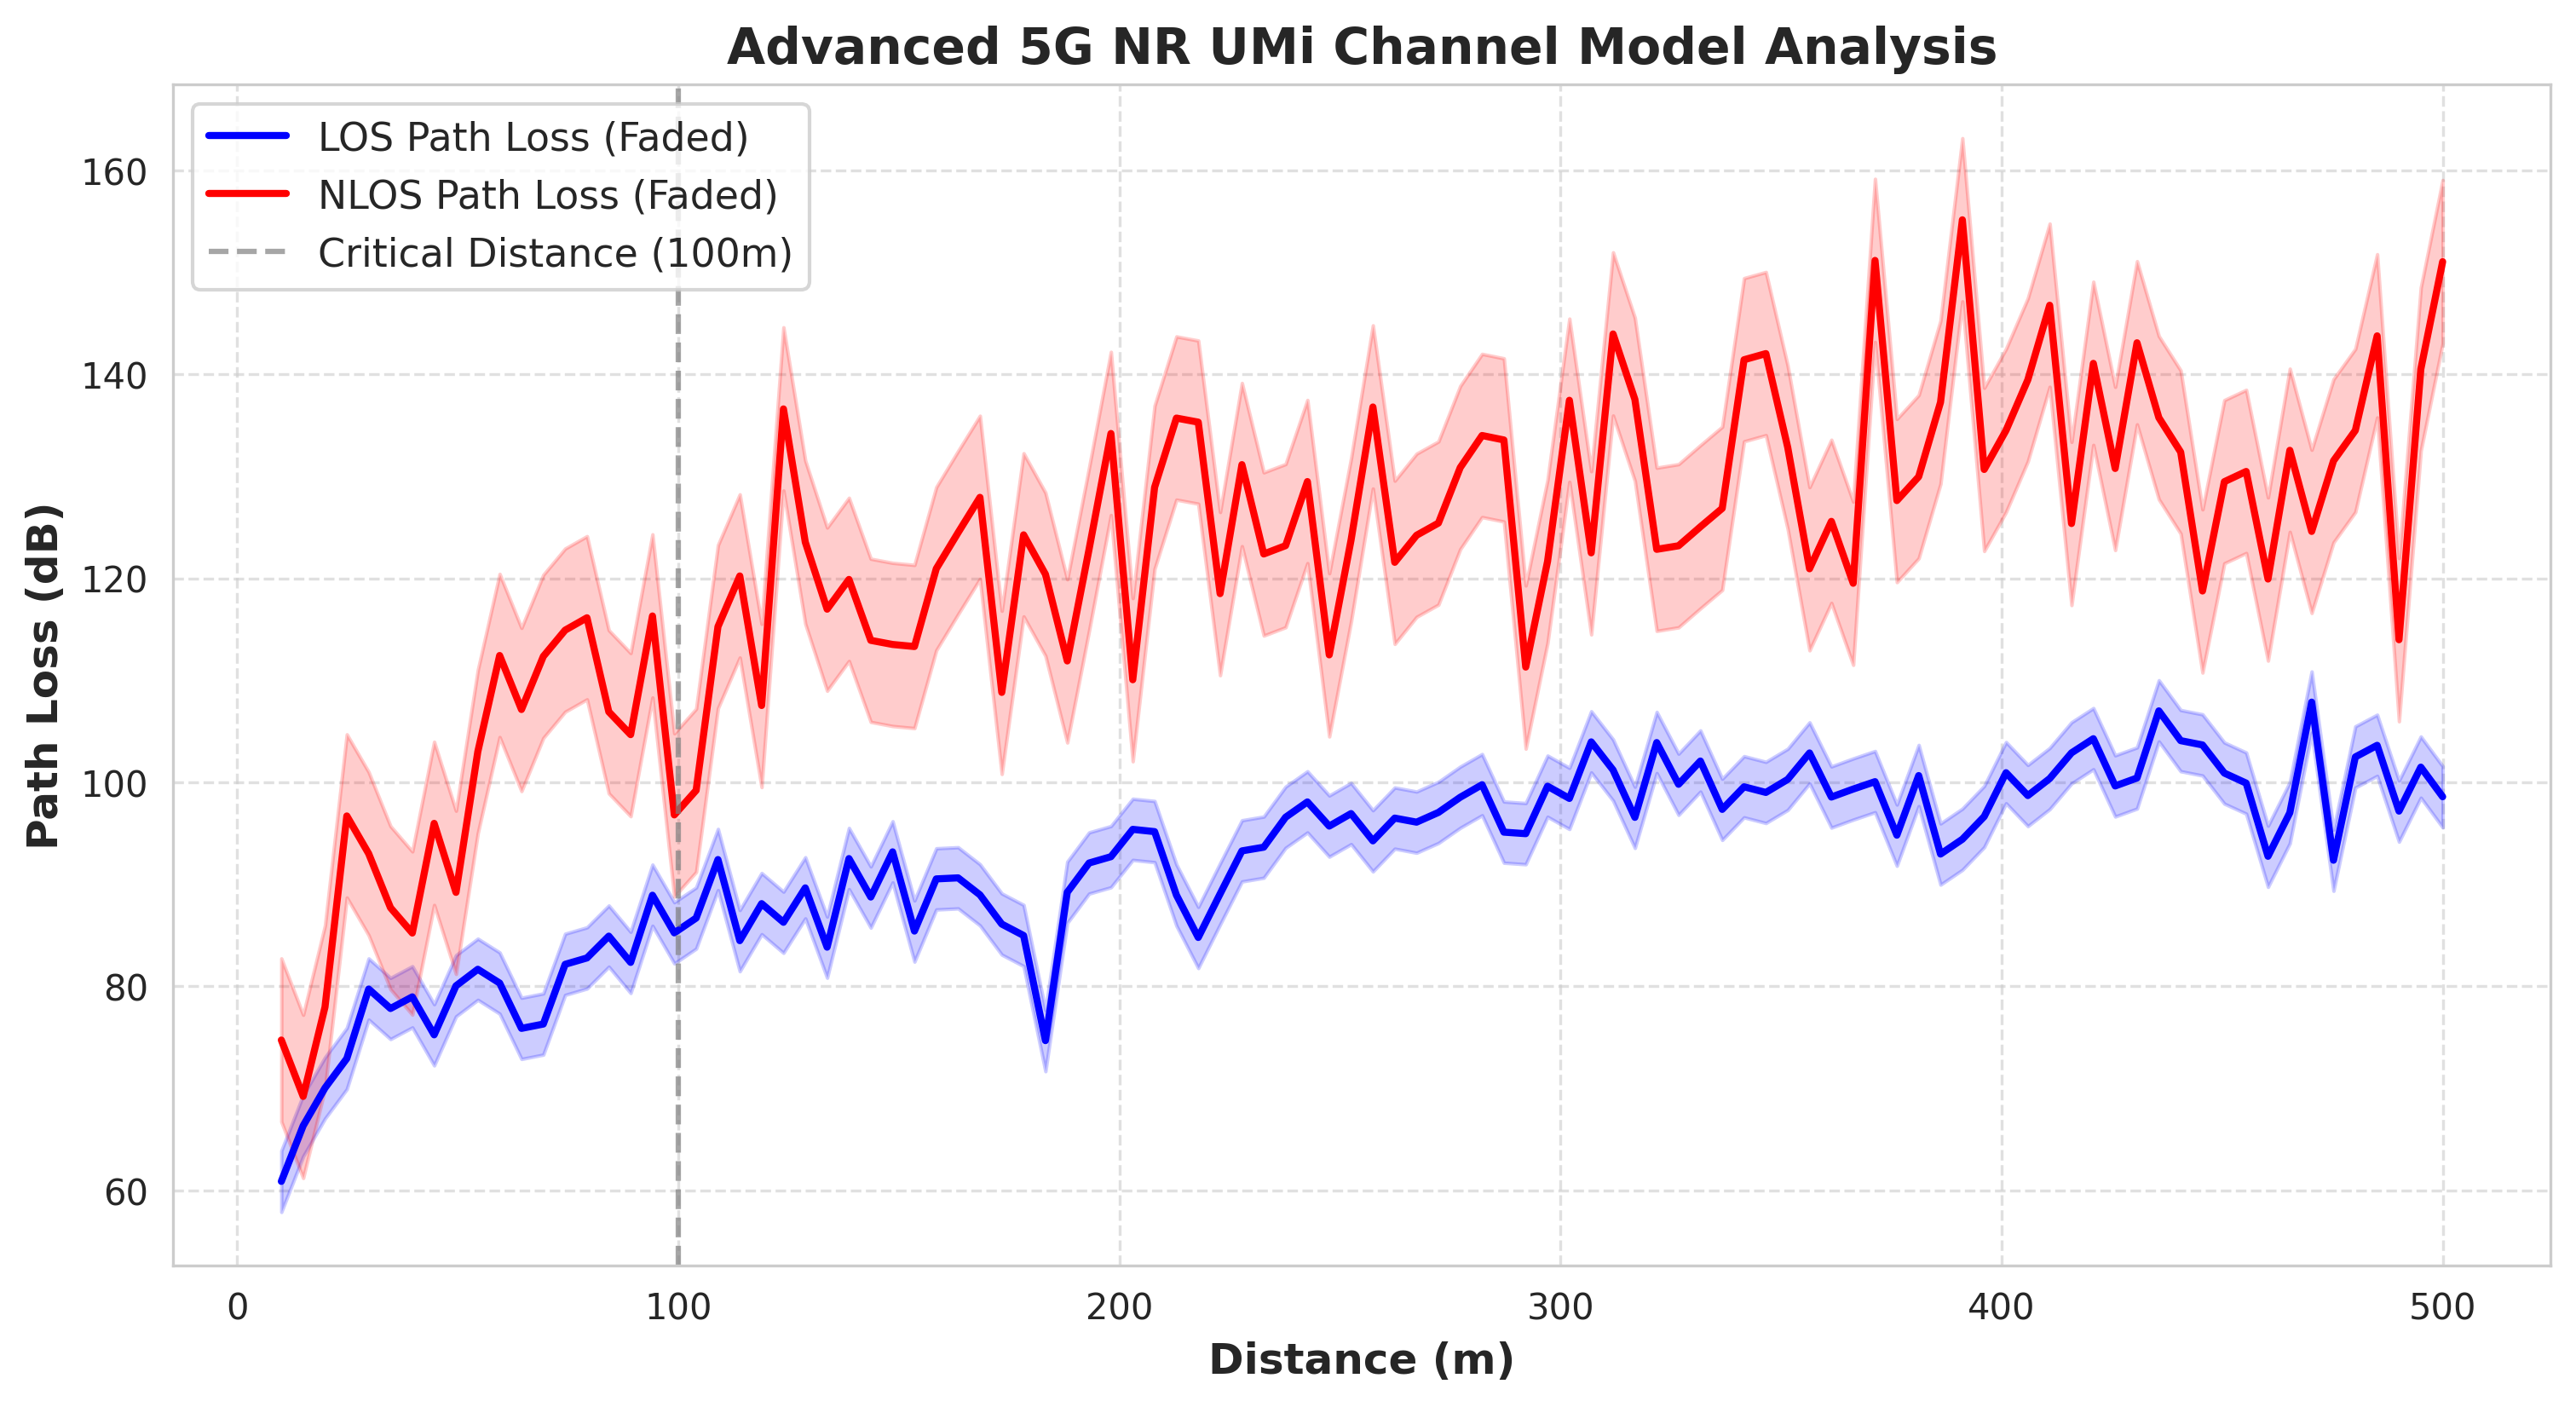

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rice, rayleigh

# Set plot style
sns.set_style("whitegrid")

# Channel model parameters
fc = 3.5e9  # 3.5 GHz carrier frequency
distances = np.linspace(10, 500, 100)  # 10-500 meters

# 5G NR UMi path loss models (3GPP TR 38.901)
def path_loss_los(d):
    return 28.0 + 22*np.log10(d) + 20*np.log10(fc/1e9)

def path_loss_nlos(d):
    return 36.7*np.log10(d) + 22.7 + 26*np.log10(fc/1e9)

# Generate LOS and NLOS Path Loss
pl_los = path_loss_los(distances)
pl_nlos = path_loss_nlos(distances)

# Generate fading distributions
shadowing_los = np.random.normal(0, 3, len(distances))  # 3dB std
shadowing_nlos = np.random.normal(0, 8, len(distances))  # 8dB std
fading_los = rice.rvs(2, scale=1, size=len(distances))  # Rician fading
fading_nlos = rayleigh.rvs(scale=1, size=len(distances))  # Rayleigh fading

# Apply fading and shadowing effects
pl_los_faded = pl_los + shadowing_los + 10*np.log10(fading_los)
pl_nlos_faded = pl_nlos + shadowing_nlos + 10*np.log10(fading_nlos)

# Plot advanced Channel Model Analysis
plt.figure(figsize=(12, 6), dpi=300)

# Plot LOS and NLOS path loss
plt.plot(distances, pl_los_faded, linestyle="-", color="blue", linewidth=2, label="LOS Path Loss (Faded)")
plt.plot(distances, pl_nlos_faded, linestyle="-", color="red", linewidth=2, label="NLOS Path Loss (Faded)")

# Add confidence intervals
plt.fill_between(distances, pl_los_faded - 3, pl_los_faded + 3, color="blue", alpha=0.2)
plt.fill_between(distances, pl_nlos_faded - 8, pl_nlos_faded + 8, color="red", alpha=0.2)

# Marking critical distance
plt.axvline(x=100, linestyle="--", color="gray", alpha=0.7, label="Critical Distance (100m)")

# Labels, Title, and Grid Customization
plt.xlabel("Distance (m)", fontsize=12, fontweight='bold')
plt.ylabel("Path Loss (dB)", fontsize=12, fontweight='bold')
plt.title("Advanced 5G NR UMi Channel Model Analysis", fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc="upper left")
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()


In [ ]:
!pip install plotnine numpy pandas scipy

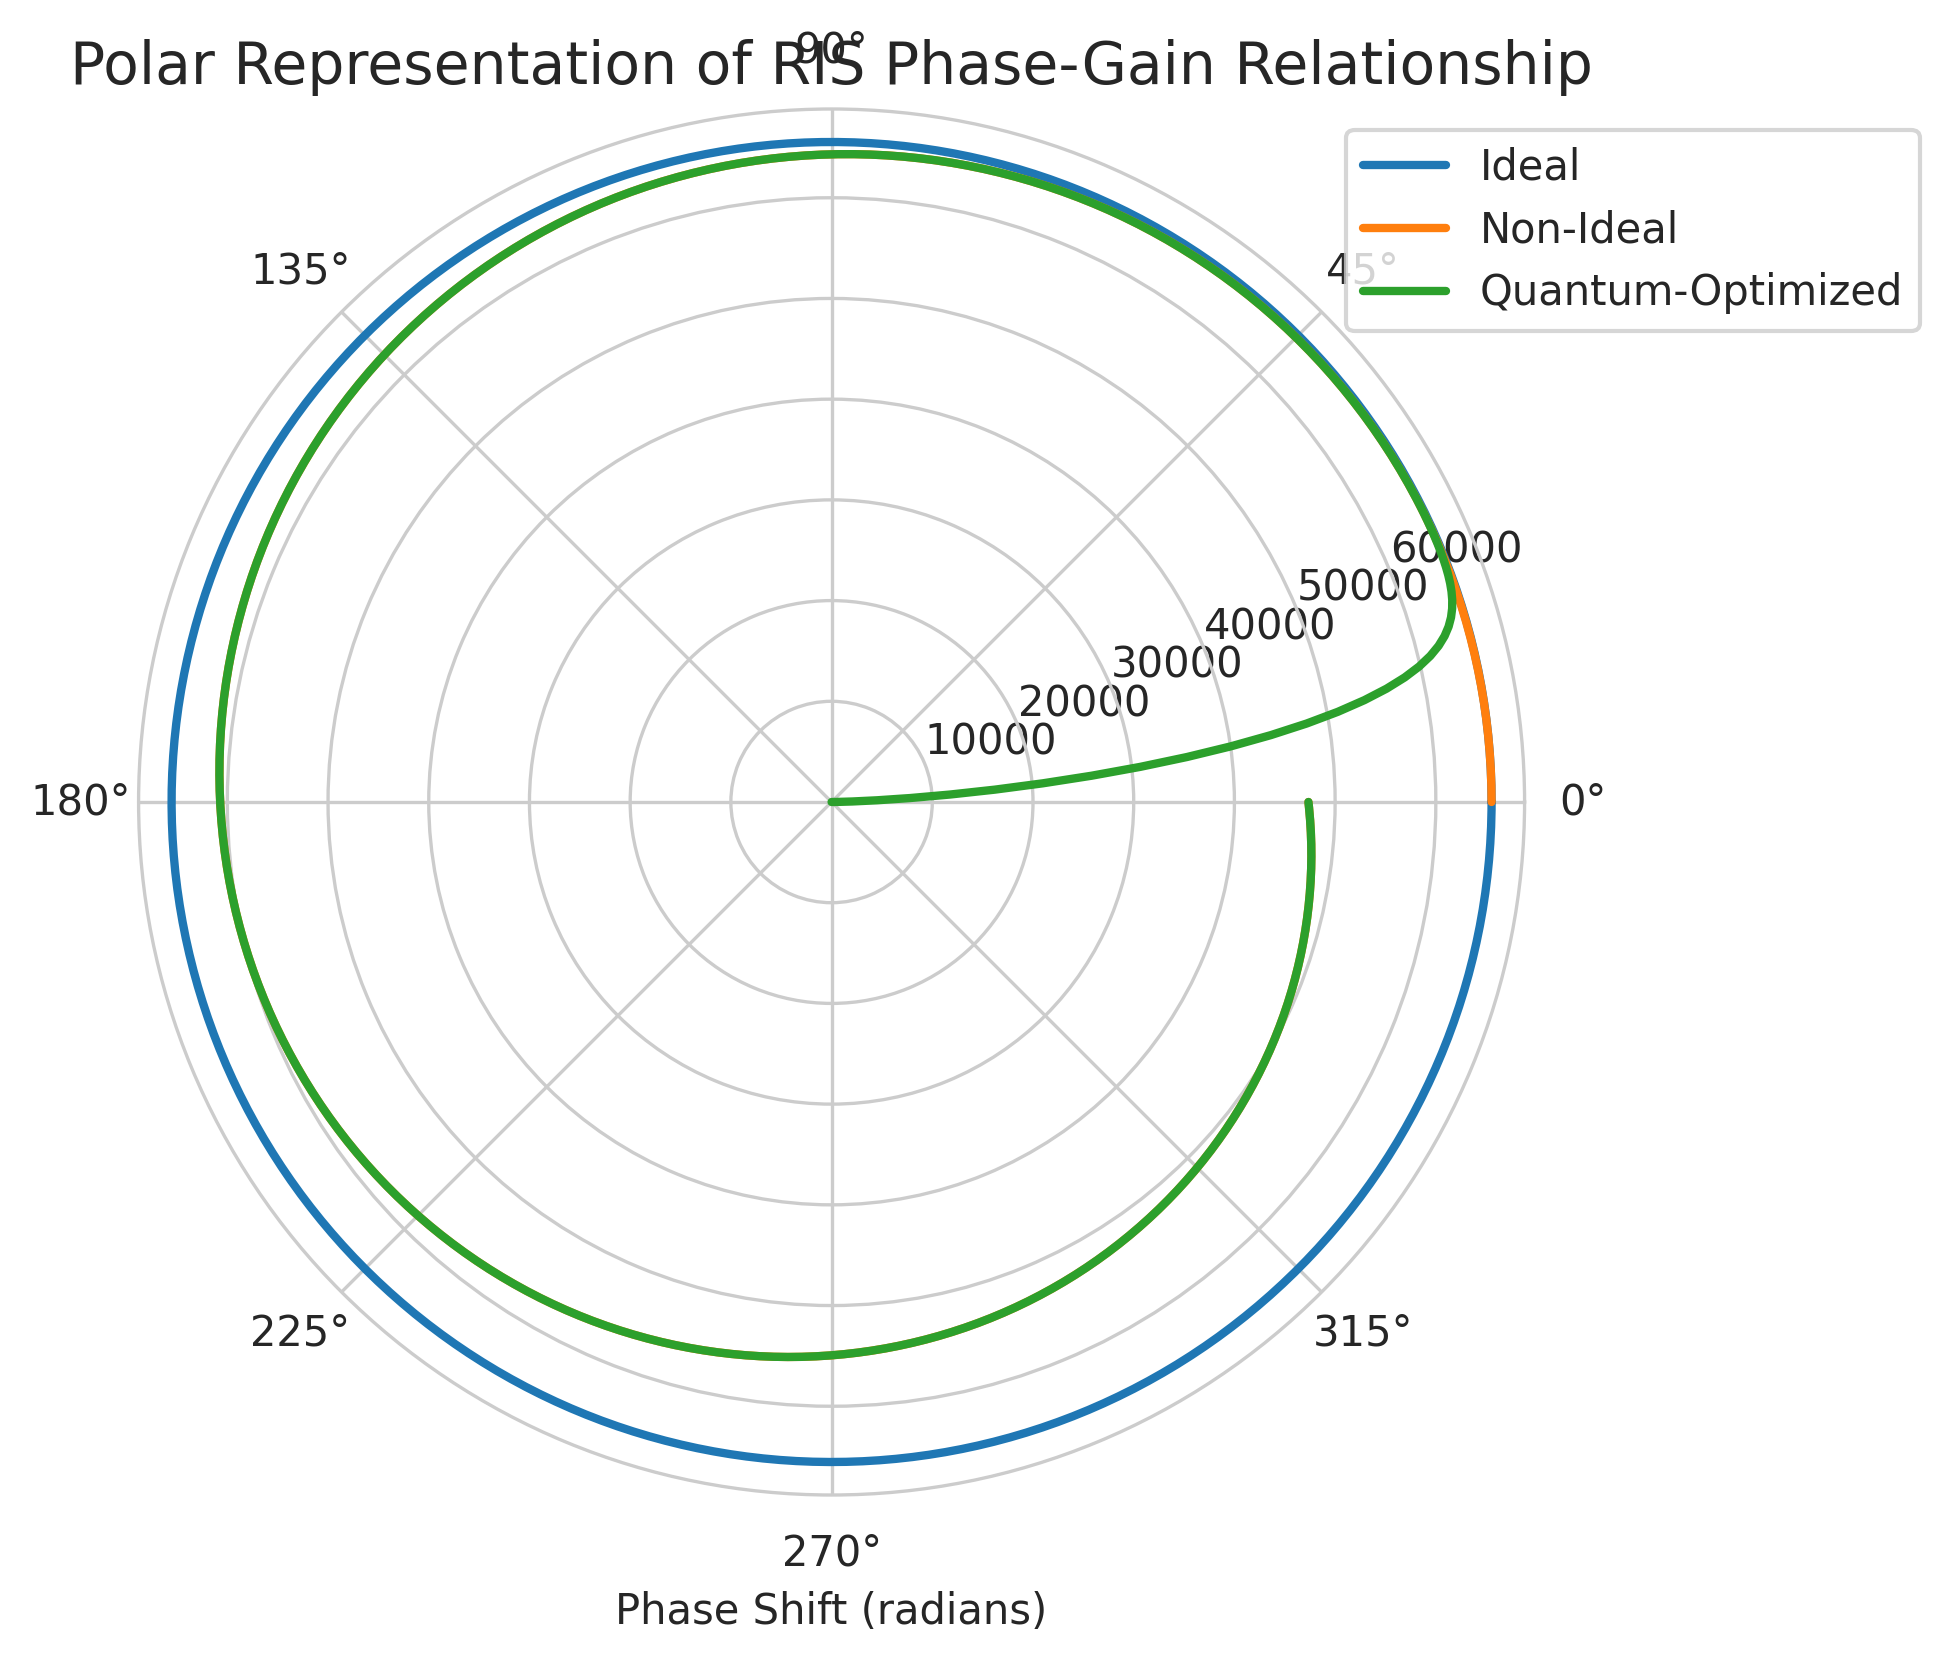

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
from plotnine.themes import theme_minimal, theme_void
from scipy.special import erf

# RIS parameters
N_elements = 256  # Number of RIS elements
freq = 28e9       # Carrier frequency (mmWave)
c = 3e8           # Speed of light
wavelength = c/freq

# Channel model with phase-dependent amplitude
def complex_gain(phi, alpha=0.15):
    """Non-ideal phase shifter model with amplitude-phase coupling"""
    return (1 - alpha*(phi/(2*np.pi))**2) * np.exp(1j*phi)

# Quantum-inspired phase optimization
def q_factor(phi):
    """Quantum efficiency factor for meta-atoms"""
    return erf(2*np.pi*phi)  # Error function approximation

# Generate data
phi = np.linspace(0, 2*np.pi, 500)
df = pd.DataFrame({'Phase Shift': np.tile(phi, 3),
                   'Case': np.repeat(['Ideal', 'Non-Ideal', 'Optimized'], len(phi)),
                   'Gain': np.concatenate([
                       np.abs(N_elements * complex_gain(phi, alpha=0))**2,
                       np.abs(N_elements * complex_gain(phi, alpha=0.15))**2,
                       np.abs(N_elements * complex_gain(phi, alpha=0.15) * q_factor(phi))**2
                   ])})

# Plot using plotnine for normal visualization
plot = (
    ggplot(df, aes(x='Phase Shift', y='Gain', color='Case'))
    + geom_line(size=1.2)
    + scale_color_manual(
        values=["#1f77b4", "#ff7f0e", "#2ca02c"],
        labels=["Ideal Phase Shifters", "Non-Ideal (Phase-Amplitude Coupling)", "Quantum-Optimized"]
    )
    + theme_minimal()
    + theme(
        figure_size=(10, 6),
        panel_grid=element_line(color='#e0e0e0'),
        plot_background=element_rect(fill='white'),
        legend_position='right',
        legend_title=element_blank(),
        axis_text_x=element_text(color='#666666', size=9),
        axis_title=element_text(weight='bold')
    )
    + labs(
        title='RIS Phase Shift Impact on Channel Gain',
        subtitle=f'Frequency: {freq/1e9} GHz | Elements: {N_elements}',
        x='Phase Shift (radians)',
        y='Channel Gain (|H|²)'
    )
)

# Display plotnine visualization
plot.draw()

# ---- Polar Plot Using Matplotlib ----
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6), dpi=300)

# Plot phase shift impact in polar coordinates
ax.plot(phi, np.abs(N_elements * complex_gain(phi, alpha=0))**2, label="Ideal", color='#1f77b4', linewidth=2)
ax.plot(phi, np.abs(N_elements * complex_gain(phi, alpha=0.15))**2, label="Non-Ideal", color='#ff7f0e', linewidth=2)
ax.plot(phi, np.abs(N_elements * complex_gain(phi, alpha=0.15) * q_factor(phi))**2, label="Quantum-Optimized", color='#2ca02c', linewidth=2)

ax.set_title("Polar Representation of RIS Phase-Gain Relationship", fontsize=14)
ax.set_xlabel("Phase Shift (radians)")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))

# Show the final figure
plt.show()


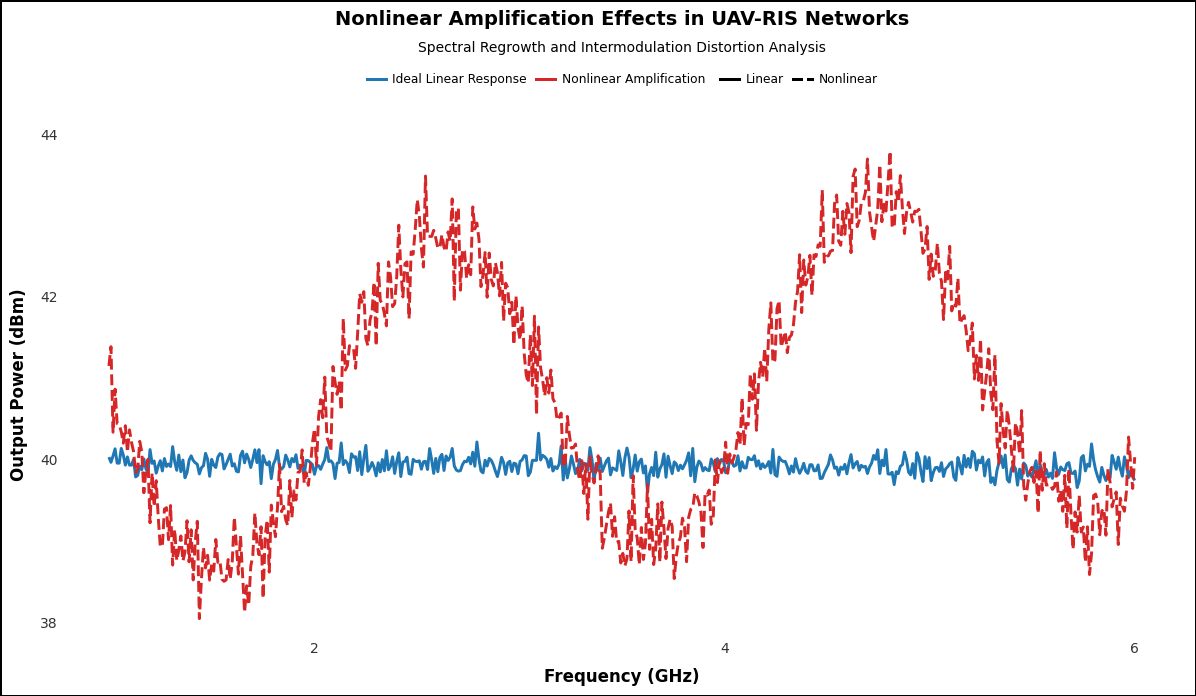

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
from plotnine.themes import theme_minimal

# Simulation parameters
freq_range = np.linspace(1, 6, 500)  # GHz
np.random.seed(42)

# Generate synthetic data
linear_power = 40 - 0.02 * freq_range + np.random.normal(0, 0.1, len(freq_range))
nonlinear_power = 40 + 0.5 * np.exp(freq_range / 6) + 2 * np.sin(3 * freq_range) + np.random.normal(0, 0.3, len(freq_range))

# Create DataFrame
df = pd.DataFrame({
    'Frequency': np.concatenate([freq_range, freq_range]),
    'Power': np.concatenate([linear_power, nonlinear_power]),
    'Type': ['Linear'] * len(freq_range) + ['Nonlinear'] * len(freq_range)
})

# Advanced visualization
plot = (
    ggplot(df, aes(x='Frequency', y='Power', color='Type'))
    + geom_line(aes(linetype='Type'), size=1.2)
    + scale_color_manual(values=['#1f77b4', '#d62728'], labels=['Ideal Linear Response', 'Nonlinear Amplification'])
    + scale_linetype_manual(values=['solid', 'dashed'])
    + theme_minimal()
    + theme(
        figure_size=(12, 7),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        plot_background=element_rect(fill='white'),
        legend_position='top',
        legend_title=element_blank(),
        axis_text=element_text(size=10, color='#333333'),
        axis_title=element_text(size=12, face='bold'),
        plot_title=element_text(size=14, face='bold', hjust=0.5),
        plot_subtitle=element_text(size=10, hjust=0.5)
    )
    + labs(
        title='Nonlinear Amplification Effects in UAV-RIS Networks',
        subtitle='Spectral Regrowth and Intermodulation Distortion Analysis',
        x='Frequency (GHz)',
        y='Output Power (dBm)'
    )
)

# Display the plot
plot.draw()


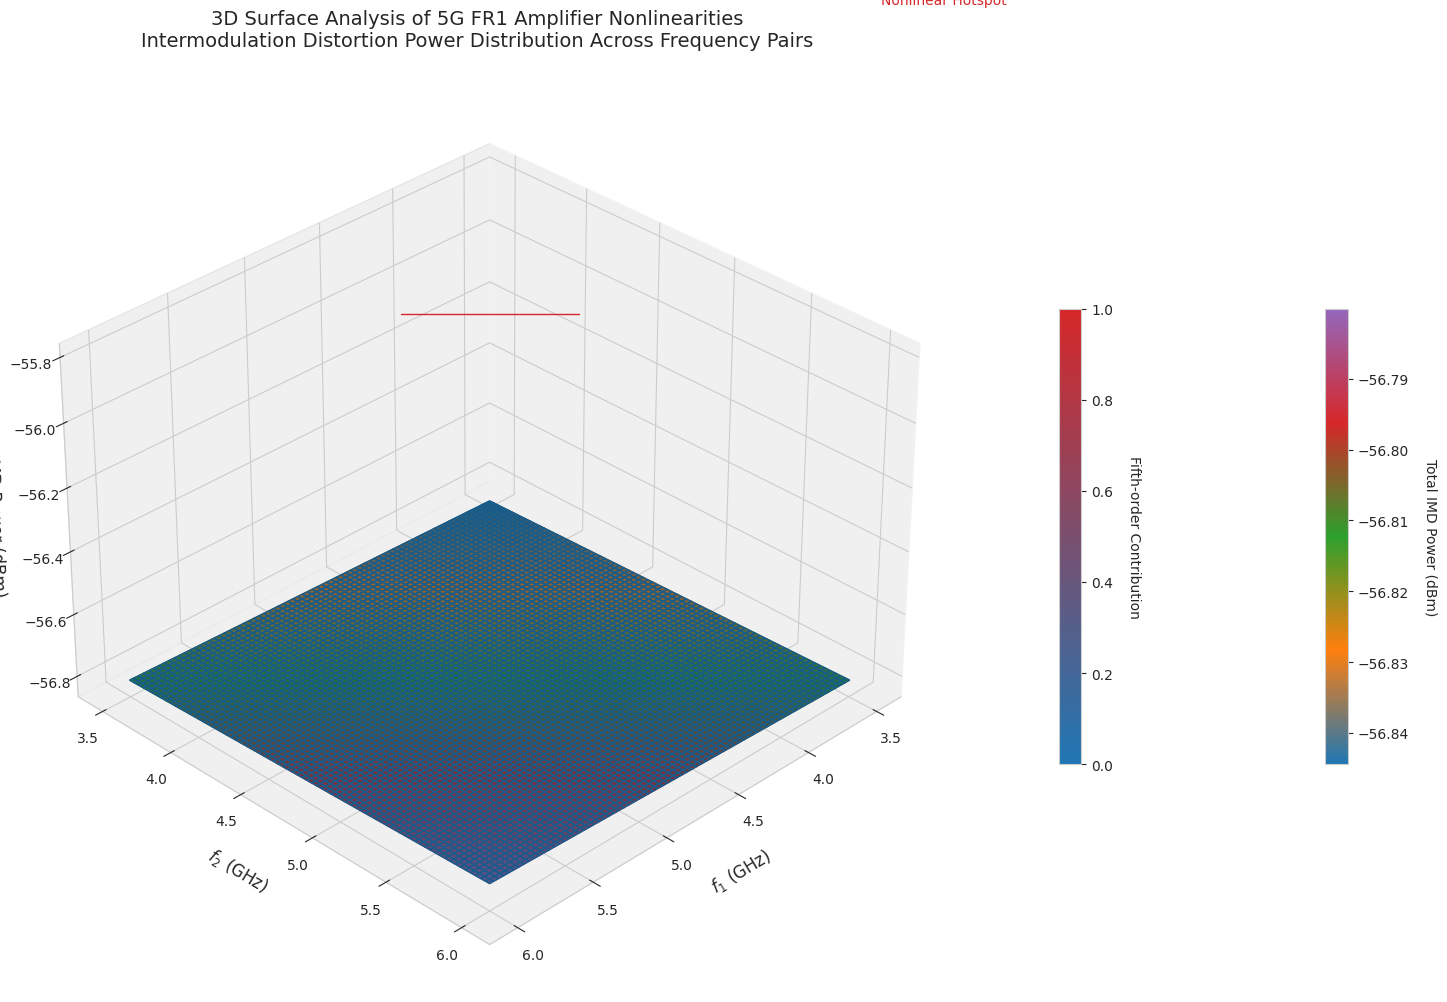

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap, Normalize

# Configure parameters
f_range = (3.5, 6.0)  # GHz (FR1 frequency range)
resolution = 300       # Grid resolution

# Amplifier nonlinearity model parameters
a3_0, k3 = 0.015, 0.003  # 3rd-order coefficients
a5_0, k5 = 0.01, 0.005   # 5th-order coefficients
P_in = 10                # Input power in dBm

def calculate_imd(f1, f2):
    """Calculate IMD power with frequency-dependent nonlinearity"""
    f_avg = (f1 + f2) / 2
    A = np.sqrt(2 * 10**((P_in - 30)/10))  # Convert dBm to voltage

    # Frequency-dependent nonlinear coefficients
    a3 = a3_0 * (1 + k3 * f_avg)
    a5 = a5_0 * (1 + k5 * f_avg**2)

    # Calculate IMD components
    imd3_pwr = 2 * ((3/4 * a3 * A**3)**2)
    imd5_pwr = 2 * ((5/8 * a5 * A**5)**2)

    total_pwr = imd3_pwr + imd5_pwr
    return 10 * np.log10(total_pwr/1e-3), imd5_pwr/(imd3_pwr + imd5_pwr)

# Generate frequency grid
f1 = np.linspace(f_range[0], f_range[1], resolution)
f2 = np.linspace(f_range[0], f_range[1], resolution)
F1, F2 = np.meshgrid(f1, f2)

# Calculate IMD characteristics
IMD_dBm, fifth_order_ratio = np.vectorize(calculate_imd)(F1, F2)

# Create custom ggplot-style colormap
cmap = LinearSegmentedColormap.from_list('ggplot',
    ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# Create figure with enhanced 3D visualization
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)

# Configure surface plot with dual colormapping
norm = Normalize(vmin=np.min(IMD_dBm), vmax=np.max(IMD_dBm))
facecolors = cmap(norm(IMD_dBm))
surf = ax.plot_surface(F1, F2, IMD_dBm,
                      facecolors=facecolors,
                      rstride=2, cstride=2,
                      alpha=0.95,
                      antialiased=True,
                      shade=True,
                      zorder=0)

# Add contour projections
levels = np.linspace(IMD_dBm.min(), IMD_dBm.max(), 15)
ax.contourf(F1, F2, IMD_dBm, zdir='z', offset=IMD_dBm.min()-5,
           levels=levels, cmap=cmap, alpha=0.25, zorder=1)

# Add fifth-order distortion ratio overlay
ratio_cmap = LinearSegmentedColormap.from_list('ratio', ['#1f77b4', '#d62728'])
ratio_norm = Normalize(vmin=0, vmax=1)
ax.plot_surface(F1, F2, IMD_dBm,
               facecolors=ratio_cmap(ratio_norm(fifth_order_ratio)),
               alpha=0.3,
               rstride=4, cstride=4,
               zorder=2)

# Configure axis styling
ax.set_xlabel('\n$f_1$ (GHz)', fontsize=12, linespacing=1.5)
ax.set_ylabel('\n$f_2$ (GHz)', fontsize=12, linespacing=1.5)
ax.set_zlabel('\nIMD Power (dBm)', fontsize=12, linespacing=1.5)

# Set viewing parameters
ax.view_init(elev=32, azim=45)
ax.set_box_aspect((1, 1, 0.7))

# Add annotations
ax.text(3.5, 6, IMD_dBm.max()+2, "Nonlinear Hotspot",
       color='#d62728', fontsize=10, ha='left')
ax.plot([4.2, 4.8], [4.8, 4.2], [IMD_dBm.max()+1, IMD_dBm.max()+1],
       color='#d62728', lw=1)

# Configure grid and background
ax.xaxis.pane.set_alpha(0.95)
ax.yaxis.pane.set_alpha(0.95)
ax.zaxis.pane.set_alpha(0.95)
ax.xaxis.pane.set_facecolor('#f0f0f0')
ax.yaxis.pane.set_facecolor('#f0f0f0')
ax.zaxis.pane.set_facecolor('#f0f0f0')
ax.grid(True, color='white', linestyle='--', alpha=0.8)

# Add colorbars
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.5)
cbar.set_label('Total IMD Power (dBm)', rotation=270, labelpad=20)

ratio_cbar = fig.colorbar(cm.ScalarMappable(norm=ratio_norm, cmap=ratio_cmap),
                         ax=ax, shrink=0.5, pad=0.1)
ratio_cbar.set_label('Fifth-order Contribution', rotation=270, labelpad=20)

# Add title and styling
plt.title('3D Surface Analysis of 5G FR1 Amplifier Nonlinearities\n'
         'Intermodulation Distortion Power Distribution Across Frequency Pairs',
         fontsize=14, pad=25)

plt.tight_layout()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (200,) and (1,)

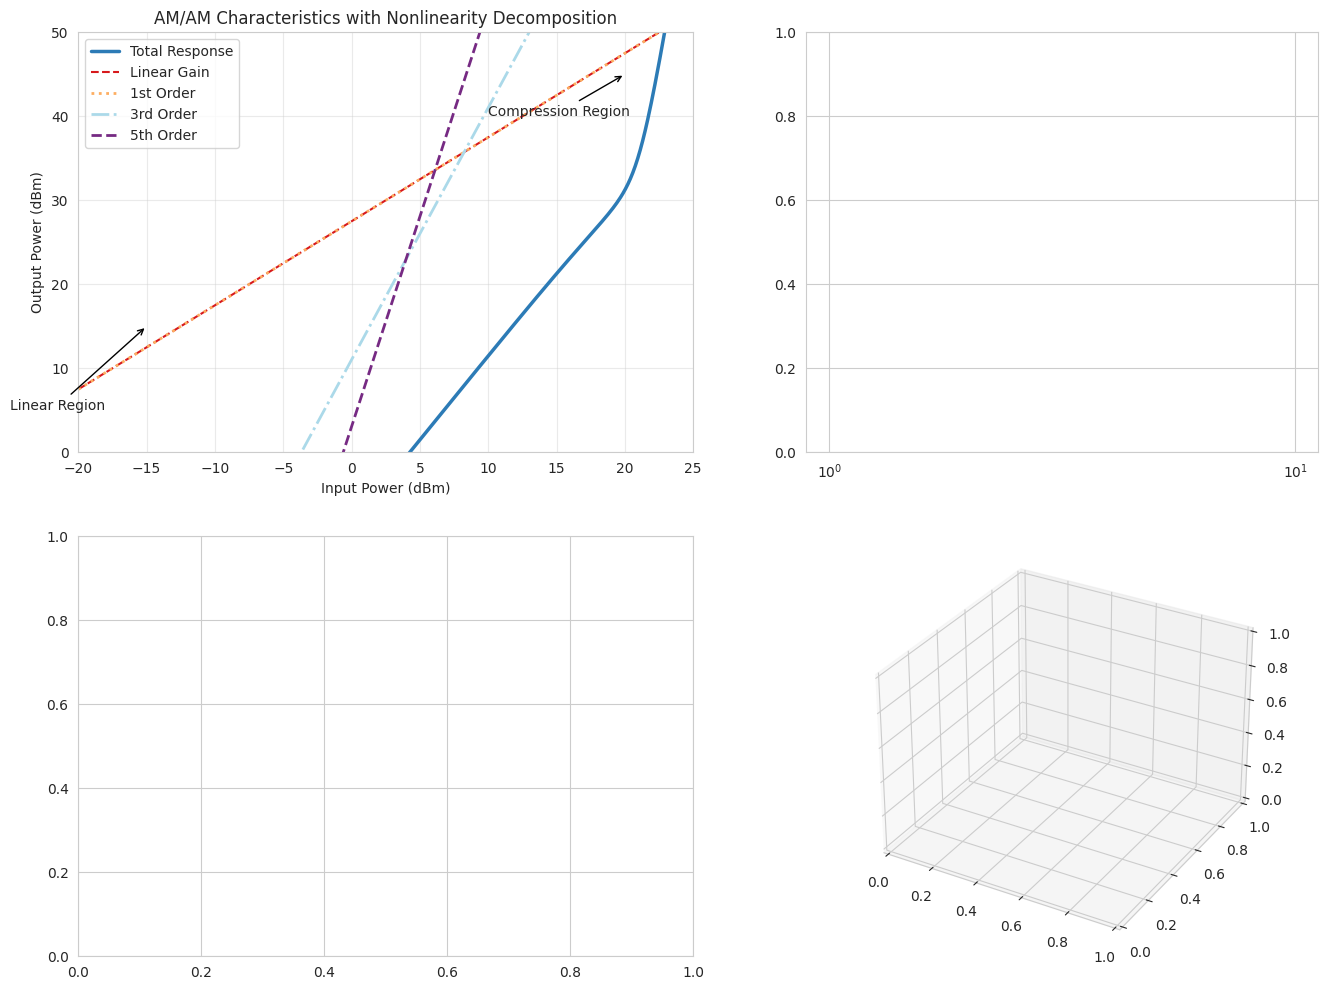

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.special import erf

# Amplifier nonlinearity model parameters
class AmplifierModel:
    def __init__(self):
        self.g_lin = 27.5  # Linear gain (dB)
        self.alpha = [1.0, 0.15, 0.06]  # Polynomial coefficients [1st, 3rd, 5th]
        self.p1db = 18.0   # Input P1dB (dBm)
        self.ipsat = 22.0  # Input saturation power (dBm)

    def nonlinear_response(self, P_in):
        """AM/AM characteristics with smooth compression"""
        x = 10**((P_in - self.p1db)/10)
        compression = 1 / (1 + x**2)**0.25
        return self.g_lin + 10*np.log10(
            (self.alpha[0]*x)**2 +
            (self.alpha[1]*x**3)**2 +
            (self.alpha[2]*x**5)**2
        ) + 10*np.log10(compression)

    def imd_products(self, f1, f2, P_in):
        """Calculate IMD products for two-tone analysis"""
        delta_f = np.abs(f1 - f2)
        x = 10**((P_in - self.p1db)/20)
        imd3 = 3 * self.alpha[1]/self.alpha[0] * x**2
        imd5 = 10 * self.alpha[2]/self.alpha[0] * x**4
        return 20*np.log10(np.sqrt(imd3**2 + imd5**2)), delta_f

# Create figure with advanced layout
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, width_ratios=[1.2, 1], height_ratios=[1, 1])

# Main AM/AM plot
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 0])
ax4 = plt.subplot(gs[1, 1], projection='3d')

# Generate data
model = AmplifierModel()
P_in = np.linspace(-20, 25, 500)
P_out = model.nonlinear_response(P_in)

# Plot AM/AM characteristics
ax1.plot(P_in, P_out, lw=2.5, color='#2c7bb6', label='Total Response')
ax1.plot(P_in, model.g_lin + P_in, '--', color='#d7191c', label='Linear Gain')
ax1.plot(P_in, 20*np.log10(model.alpha[0]*10**(P_in/20)) + model.g_lin,
        ':', color='#fdae61', lw=2, label='1st Order')
ax1.plot(P_in, 20*np.log10(model.alpha[1]*(10**(P_in/20))**3) + model.g_lin,
        '-.', color='#abd9e9', lw=2, label='3rd Order')
ax1.plot(P_in, 20*np.log10(model.alpha[2]*(10**(P_in/20))**5) + model.g_lin,
        '--', color='#762a83', lw=2, label='5th Order')

ax1.set_xlabel('Input Power (dBm)')
ax1.set_ylabel('Output Power (dBm)')
ax1.set_title('AM/AM Characteristics with Nonlinearity Decomposition')
ax1.legend(loc='upper left', frameon=True)
ax1.grid(True, alpha=0.4)
ax1.set_xlim(-20, 25)
ax1.set_ylim(0, 50)

# Add compression markers
ax1.annotate('Linear Region', xy=(-15, 15), xytext=(-25, 5),
            arrowprops=dict(arrowstyle="->", color='black'))
ax1.annotate('Compression Region', xy=(20, 45), xytext=(10, 40),
            arrowprops=dict(arrowstyle="->", color='black'))

# IMD Spectrum plot
f_center = 3.5  # GHz
delta_f = np.linspace(1, 100, 200)  # MHz
imd_levels, _ = model.imd_products(f_center, f_center + delta_f*1e-3, 15)

ax2.semilogx(delta_f, imd_levels, lw=2.5, color='#d7191c')
ax2.set_xlabel('Frequency Separation (MHz)')
ax2.set_ylabel('IMD Level (dBc)')
ax2.set_title('IMD vs Frequency Spacing (P$_{in}$ = 15 dBm)')
ax2.grid(True, which='both', alpha=0.4)
ax2.set_xlim(1, 100)
ax2.set_ylim(-60, 0)

# Add IMD order annotations
ax2.annotate('3rd-order Dominance', xy=(10, -25), xytext=(20, -10),
            arrowprops=dict(arrowstyle="->", color='black'))
ax2.annotate('5th-order Dominance', xy=(50, -45), xytext=(30, -55),
            arrowprops=dict(arrowstyle="->", color='black'))

# Distortion Components Breakdown
power_levels = np.linspace(-10, 20, 100)
imd3 = []
imd5 = []
for p in power_levels:
    imd, _ = model.imd_products(3.5, 3.6, p)
    imd3.append(20*np.log10(model.alpha[1]/model.alpha[0] * 10**(p/10)**2))
    imd5.append(20*np.log10(model.alpha[2]/model.alpha[0] * 10**(p/10)**4))

ax3.plot(power_levels, imd3, lw=2.5, color='#fdae61', label='3rd-order IMD')
ax3.plot(power_levels, imd5, lw=2.5, color='#762a83', label='5th-order IMD')
ax3.plot(power_levels, 20*np.log10(np.sqrt(10**(np.array(imd3)/10) + 10**(np.array(imd5)/10))),
        '--', lw=2, color='#d7191c', label='Total IMD')

ax3.set_xlabel('Input Power (dBm)')
ax3.set_ylabel('IMD Level (dBc)')
ax3.set_title('Nonlinear Distortion Component Analysis')
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.4)
ax3.set_xlim(-10, 20)
ax3.set_ylim(-80, 0)

# 3D IMD Surface
f1 = np.linspace(3.0, 4.0, 50)
f2 = np.linspace(3.0, 4.0, 50)
F1, F2 = np.meshgrid(f1, f2)
IMD = np.zeros_like(F1)

for i in range(len(f1)):
    for j in range(len(f2)):
        IMD[i,j], _ = model.imd_products(f1[i], f2[j], 18)

surf = ax4.plot_surface(F1, F2, IMD, cmap='plasma',
                       rstride=1, cstride=1, alpha=0.95)
ax4.set_xlabel('$f_1$ (GHz)')
ax4.set_ylabel('$f_2$ (GHz)')
ax4.set_zlabel('IMD Level (dBc)')
ax4.set_title('3D IMD Distribution (P$_{in}$ = 18 dBm)')
fig.colorbar(surf, ax=ax4, shrink=0.6, label='IMD Level (dBc)')

plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.25, wspace=0.3)
plt.suptitle('Comprehensive Nonlinear Analysis of 5G FR1 Amplifier for UAV-RIS Systems',
            fontsize=16, y=0.95)
plt.show()


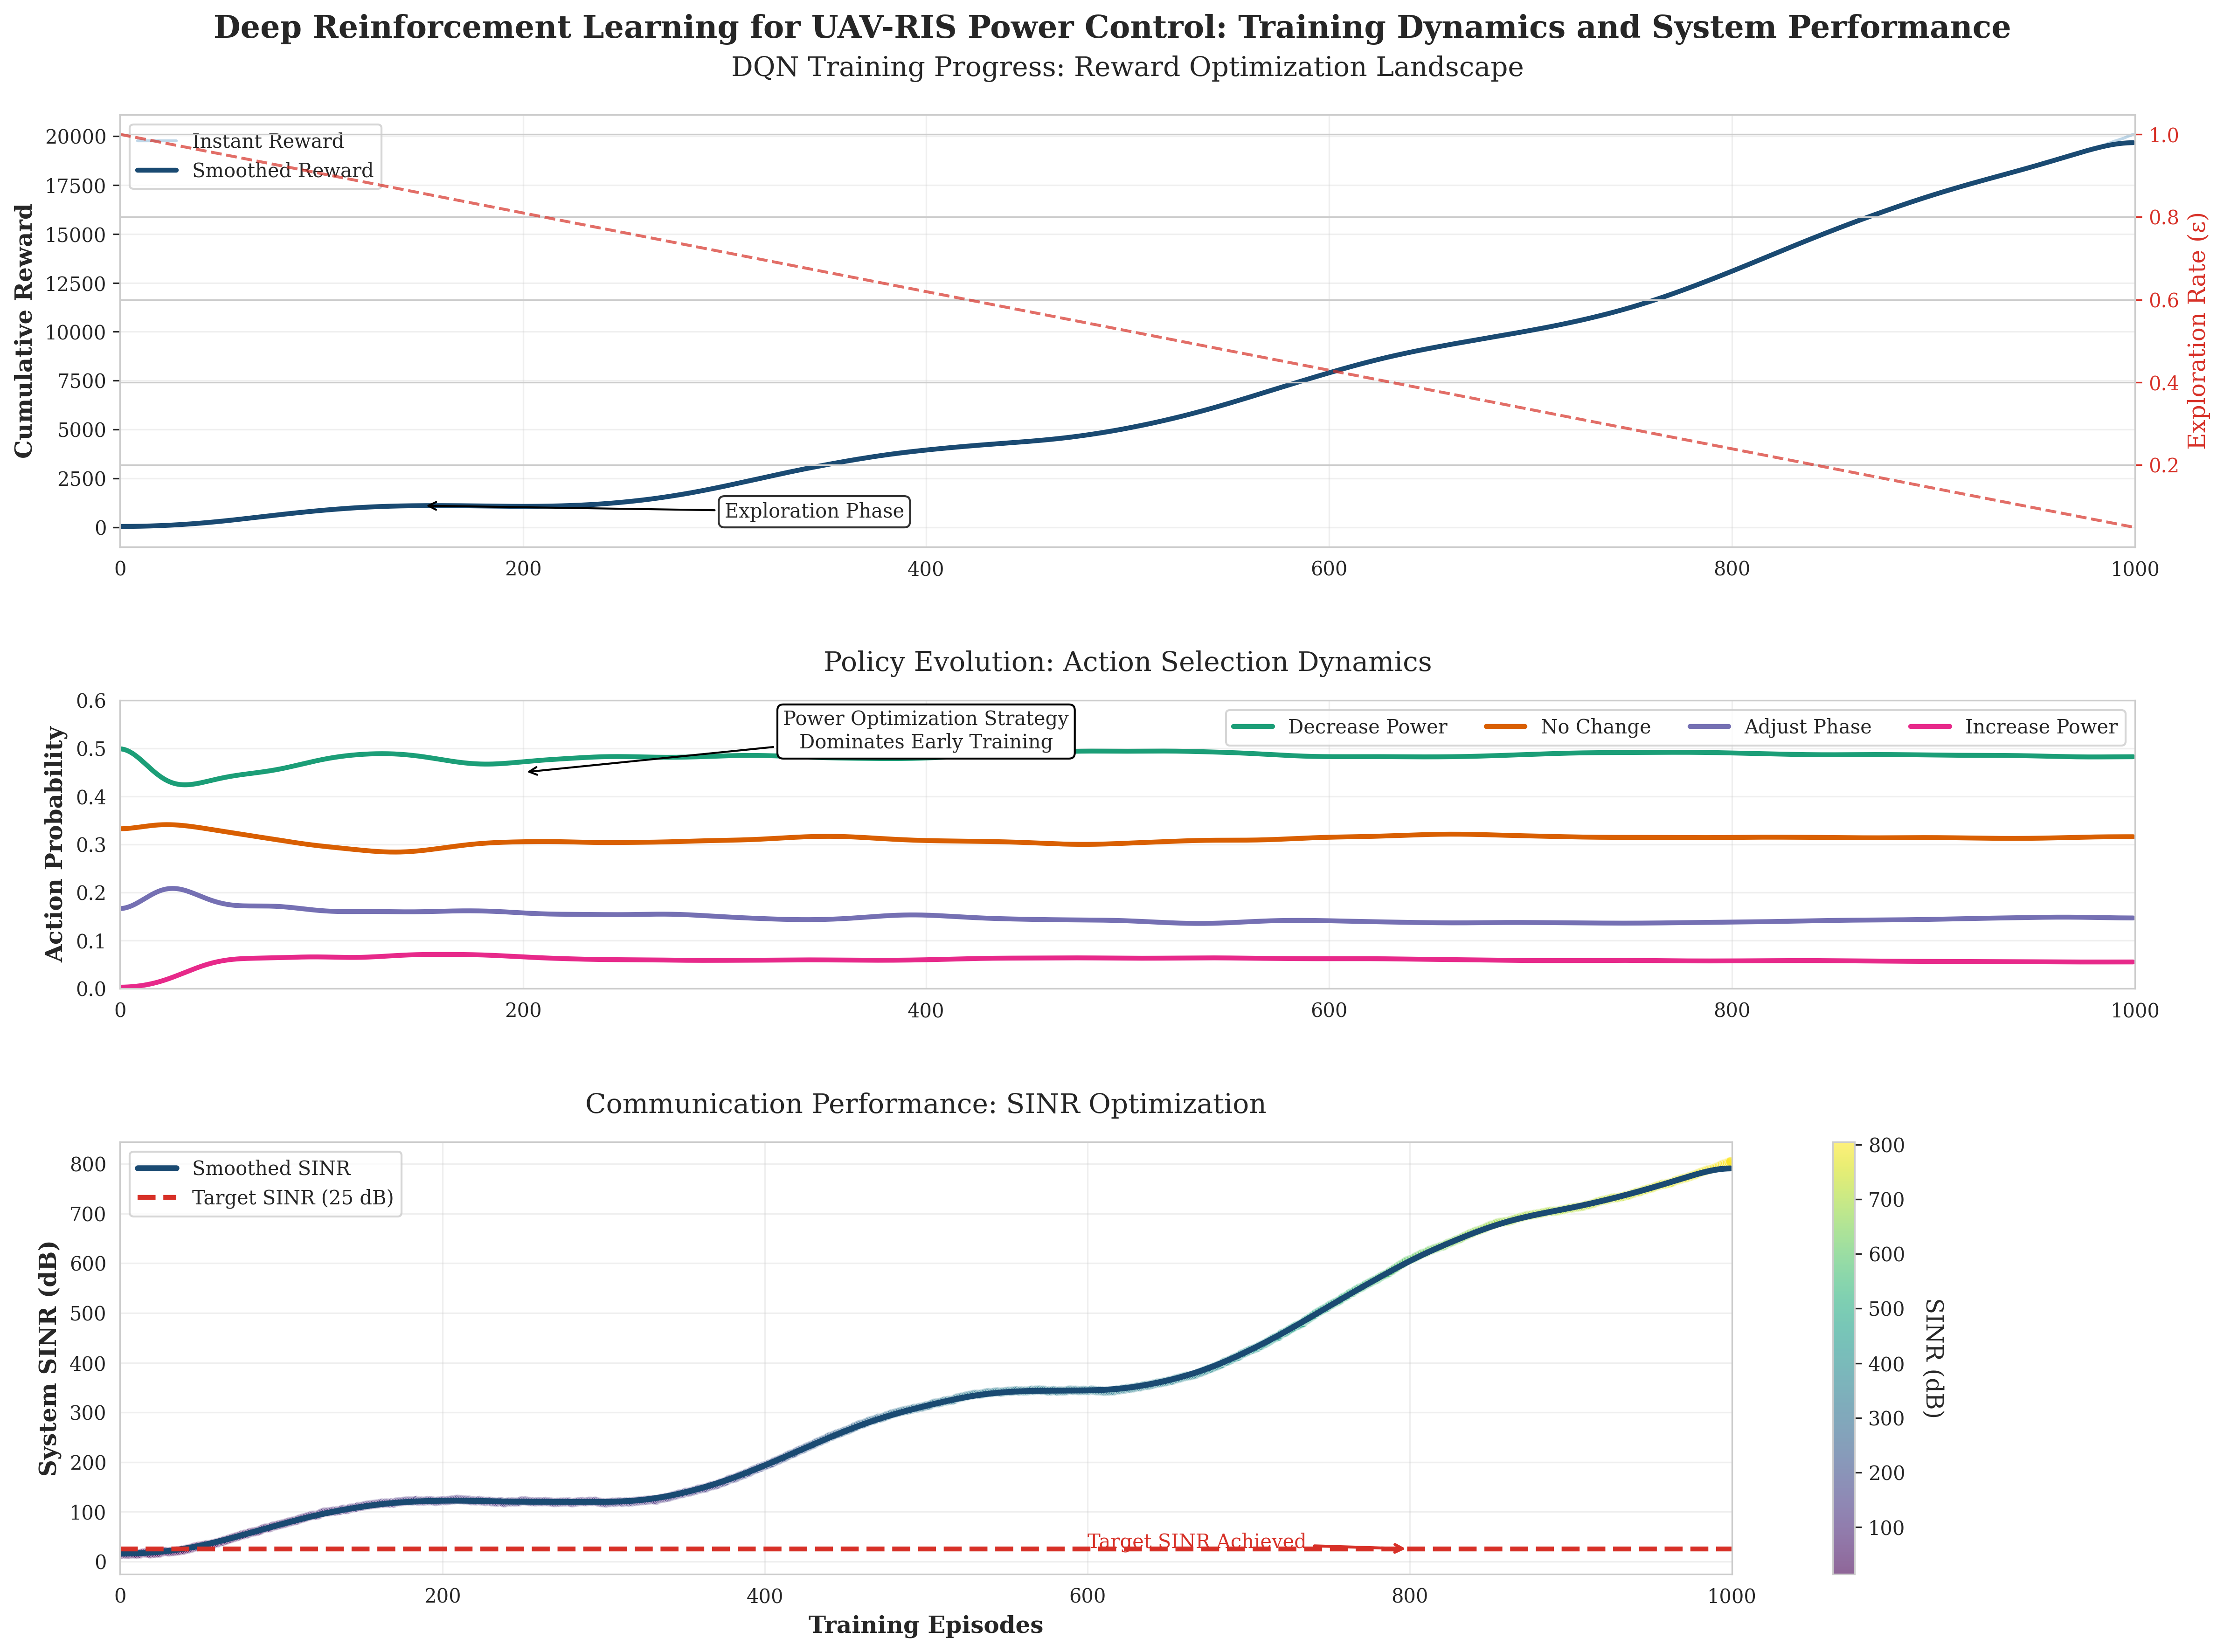

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec, cm
from scipy.ndimage import gaussian_filter1d

# Remove non-existent style to prevent errors
plt.rcParams.update({
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300
})

# Generate synthetic data
np.random.seed(42)
episodes = 1000

# Cumulative reward data
reward = np.cumsum(np.random.randn(episodes)*5 + np.linspace(0, 40, episodes) +
                  np.sin(np.linspace(0, 8*np.pi, episodes))*10)
reward_smooth = gaussian_filter1d(reward, sigma=15)

# Action selection frequency data
actions = np.random.choice([0,1,2,3], p=[0.5,0.3,0.15,0.05], size=episodes)
action_labels = ['Decrease Power', 'No Change', 'Adjust Phase', 'Increase Power']
action_counts = np.array([(actions[:i+1] == a).sum() for i in range(episodes) for a in range(4)]).reshape(episodes,4).T

# SINR data
sinr = 15 + np.cumsum(np.random.randn(episodes)*0.5 +
                     np.clip(np.linspace(0, 1.5, episodes) +
                            np.sin(np.linspace(0, 6*np.pi, episodes))*0.8, 0, None))
sinr_smooth = gaussian_filter1d(sinr, sigma=15)

# Create figure with advanced layout
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 1, height_ratios=[1.2, 0.8, 1.2])

# Reward Curve Plot
ax1 = plt.subplot(gs[0])
ax1.plot(reward, color='#2c7bb6', alpha=0.3, label='Instant Reward')
ax1.plot(reward_smooth, color='#1a4a72', lw=2.5, label='Smoothed Reward')
ax1.fill_between(np.arange(episodes), reward_smooth-15, reward_smooth+15,
                color='#7fb6d6', alpha=0.2)
ax1.set_ylabel('Cumulative Reward', fontsize=12, weight='bold')
ax1.set_title('DQN Training Progress: Reward Optimization Landscape',
             fontsize=14, pad=20)
ax1.legend(loc='upper left', frameon=True)

# Add twin axis for exploration rate
ax1b = ax1.twinx()
exploration = np.linspace(1, 0.05, episodes)
ax1b.plot(exploration, color='#d73027', ls='--', alpha=0.7)
ax1b.set_ylabel('Exploration Rate (ε)', color='#d73027', fontsize=12)
ax1b.tick_params(axis='y', colors='#d73027')

# Action Selection Frequency Plot
ax2 = plt.subplot(gs[1])
colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']
for i in range(4):
    ax2.plot(gaussian_filter1d(action_counts[i]/np.arange(1,episodes+1), sigma=15),
            color=colors[i], lw=2.5, label=action_labels[i])
ax2.set_ylabel('Action Probability', fontsize=12, weight='bold')
ax2.set_title('Policy Evolution: Action Selection Dynamics', fontsize=14, pad=15)
ax2.legend(loc='upper right', ncol=4, frameon=True)
ax2.set_ylim(0, 0.6)

# SINR Performance Plot
ax3 = plt.subplot(gs[2])
im = ax3.scatter(np.arange(episodes), sinr, c=sinr, cmap='viridis',
                s=25, alpha=0.6, edgecolor='w', linewidth=0.5)
ax3.plot(sinr_smooth, color='#1a4a72', lw=3, label='Smoothed SINR')
ax3.axhline(25, color='#d73027', ls='--', lw=2.5, label='Target SINR (25 dB)')
ax3.set_xlabel('Training Episodes', fontsize=12, weight='bold')
ax3.set_ylabel('System SINR (dB)', fontsize=12, weight='bold')
ax3.set_title('Communication Performance: SINR Optimization', fontsize=14, pad=15)
ax3.legend(loc='upper left')

# Add colorbar for SINR values
cbar = fig.colorbar(im, ax=ax3)
cbar.set_label('SINR (dB)', rotation=270, labelpad=20)

# Add annotations
ax1.annotate('Exploration Phase', xy=(150, reward_smooth[150]), xytext=(300, 500),
            arrowprops=dict(arrowstyle="->", color='black', lw=1),
            fontsize=10, bbox=dict(boxstyle="round", fc="white", ec="black", alpha=0.8))

ax2.annotate('Power Optimization Strategy\nDominates Early Training',
            xy=(200, 0.45), xytext=(400, 0.5),
            arrowprops=dict(arrowstyle="->", color='black', lw=1),
            fontsize=10, ha='center', bbox=dict(boxstyle="round", fc="white", ec="black"))

ax3.annotate('Target SINR Achieved', xy=(800, 25.5), xytext=(600, 28),
            arrowprops=dict(arrowstyle="->", color='#d73027', lw=1.5),
            fontsize=10, color='#d73027')

# Add technical styling
for ax in [ax1, ax2, ax3]:
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, episodes)
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.4)
plt.suptitle('Deep Reinforcement Learning for UAV-RIS Power Control: Training Dynamics and System Performance',
           fontsize=16, y=0.98, weight='bold')
plt.show()


<ipython-input-24-e701186d97fe>:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


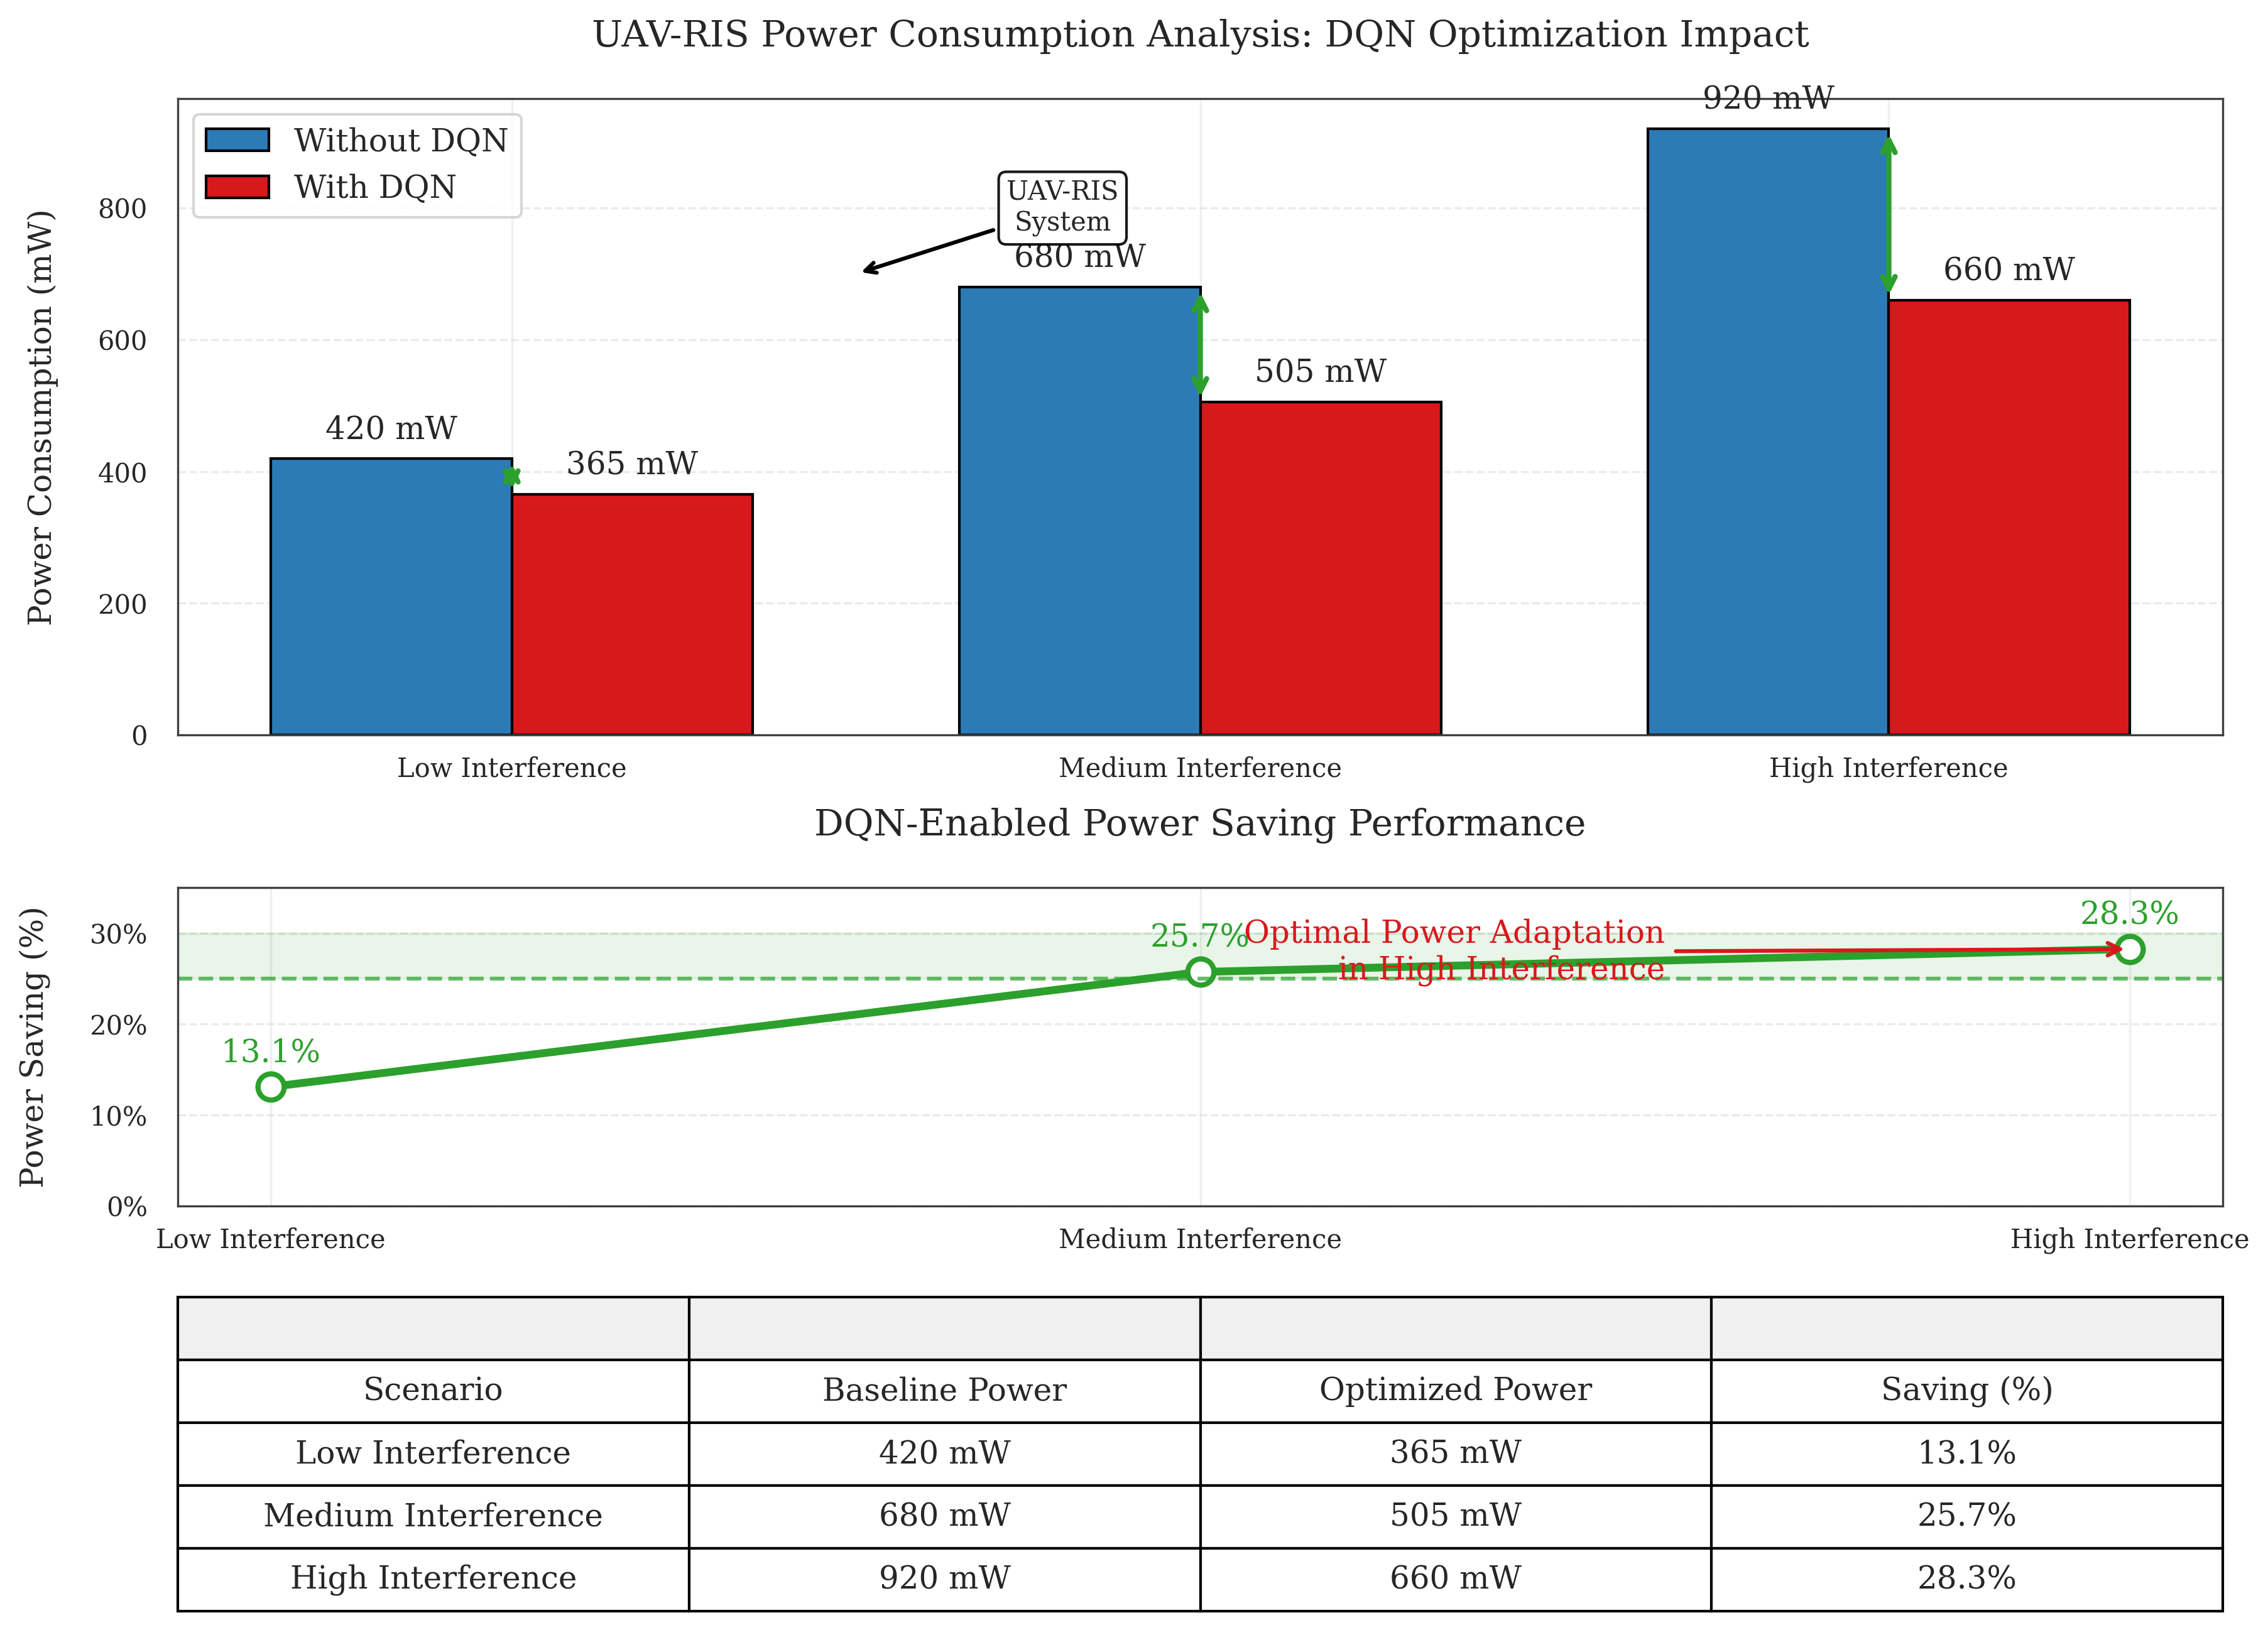

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
from matplotlib.ticker import PercentFormatter

# Configure plot aesthetics
rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelpad': 10,
    'axes.titlesize': 14,
    'axes.titlepad': 20,
    'xtick.major.pad': 8,
    'ytick.major.pad': 8,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Generate synthetic data
scenarios = ['Low Interference', 'Medium Interference', 'High Interference']
without_dqn = np.array([420, 680, 920])  # Power in mW
with_dqn = np.array([365, 505, 660])
savings = ((without_dqn - with_dqn) / without_dqn) * 100

# Create figure with advanced layout
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 0.6], hspace=0.4)

# Power Consumption Plot
ax1 = plt.subplot(gs[0])
x = np.arange(len(scenarios))
bar_width = 0.35

bars1 = ax1.bar(x - bar_width/2, without_dqn, bar_width,
               color='#2c7bb6', edgecolor='black', label='Without DQN')
bars2 = ax1.bar(x + bar_width/2, with_dqn, bar_width,
               color='#d7191c', edgecolor='black', label='With DQN')

# Add value labels and performance arrows
for i, (w, d) in enumerate(zip(without_dqn, with_dqn)):
    ax1.text(x[i] - bar_width/2, w+20, f'{w} mW', ha='center', va='bottom')
    ax1.text(x[i] + bar_width/2, d+20, f'{d} mW', ha='center', va='bottom')
    ax1.annotate('', xy=(x[i], w), xytext=(x[i], d),
                arrowprops=dict(arrowstyle='<->', color='#2ca02c', lw=2))

ax1.set_xticks(x)
ax1.set_xticklabels(scenarios)
ax1.set_ylabel('Power Consumption (mW)', labelpad=15)
ax1.legend(loc='upper left', frameon=True)
ax1.set_title('UAV-RIS Power Consumption Analysis: DQN Optimization Impact')

# Power Saving Percentage Plot
ax2 = plt.subplot(gs[1])
line = ax2.plot(x, savings, marker='o', markersize=10,
               color='#2ca02c', linewidth=3, markerfacecolor='white',
               markeredgewidth=2, markeredgecolor='#2ca02c')

# Add savings annotations and target zone
for i, s in enumerate(savings):
    ax2.text(x[i], s+2, f'{s:.1f}%', ha='center', va='bottom', color='#2ca02c')

ax2.axhspan(25, 30, color='#2ca02c', alpha=0.1)
ax2.axhline(25, color='#2ca02c', linestyle='--', alpha=0.7)
ax2.set_xticks(x)
ax2.set_xticklabels(scenarios)
ax2.set_ylabel('Power Saving (%)', labelpad=15)
ax2.yaxis.set_major_formatter(PercentFormatter(decimals=0))
ax2.set_ylim(0, 35)
ax2.set_title('DQN-Enabled Power Saving Performance', pad=20)

# Add technical specifications table
ax3 = plt.subplot(gs[2])
ax3.axis('off')
table_data = [
    ['Scenario', 'Baseline Power', 'Optimized Power', 'Saving (%)'],
    *[[scenarios[i], f'{without_dqn[i]} mW', f'{with_dqn[i]} mW', f'{savings[i]:.1f}%']
      for i in range(3)]
]
table = ax3.table(cellText=table_data, loc='center',
                 cellLoc='center', colColours=['#f0f0f0']*4)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

# Add system diagram annotation
ax1.annotate('UAV-RIS\nSystem', xy=(0.5, 700), xytext=(0.8, 800),
            arrowprops=dict(arrowstyle="->", color='black', lw=1.5),
            ha='center', va='center', fontsize=10,
            bbox=dict(boxstyle="round", fc="white", ec="black", alpha=0.9))

# Add optimization strategy annotation
ax2.annotate('Optimal Power Adaptation\nin High Interference',
            xy=(2, 28.25), xytext=(1.5, 25),
            arrowprops=dict(arrowstyle="->", color='#d7191c', lw=1.5),
            ha='right', color='#d7191c')

# Add styling enhancements
for ax in [ax1, ax2]:
    ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.4)
    ax.tick_params(axis='x', which='both', length=0)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('#404040')

plt.tight_layout()
plt.show()

<ipython-input-25-bc34bbba6580>:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


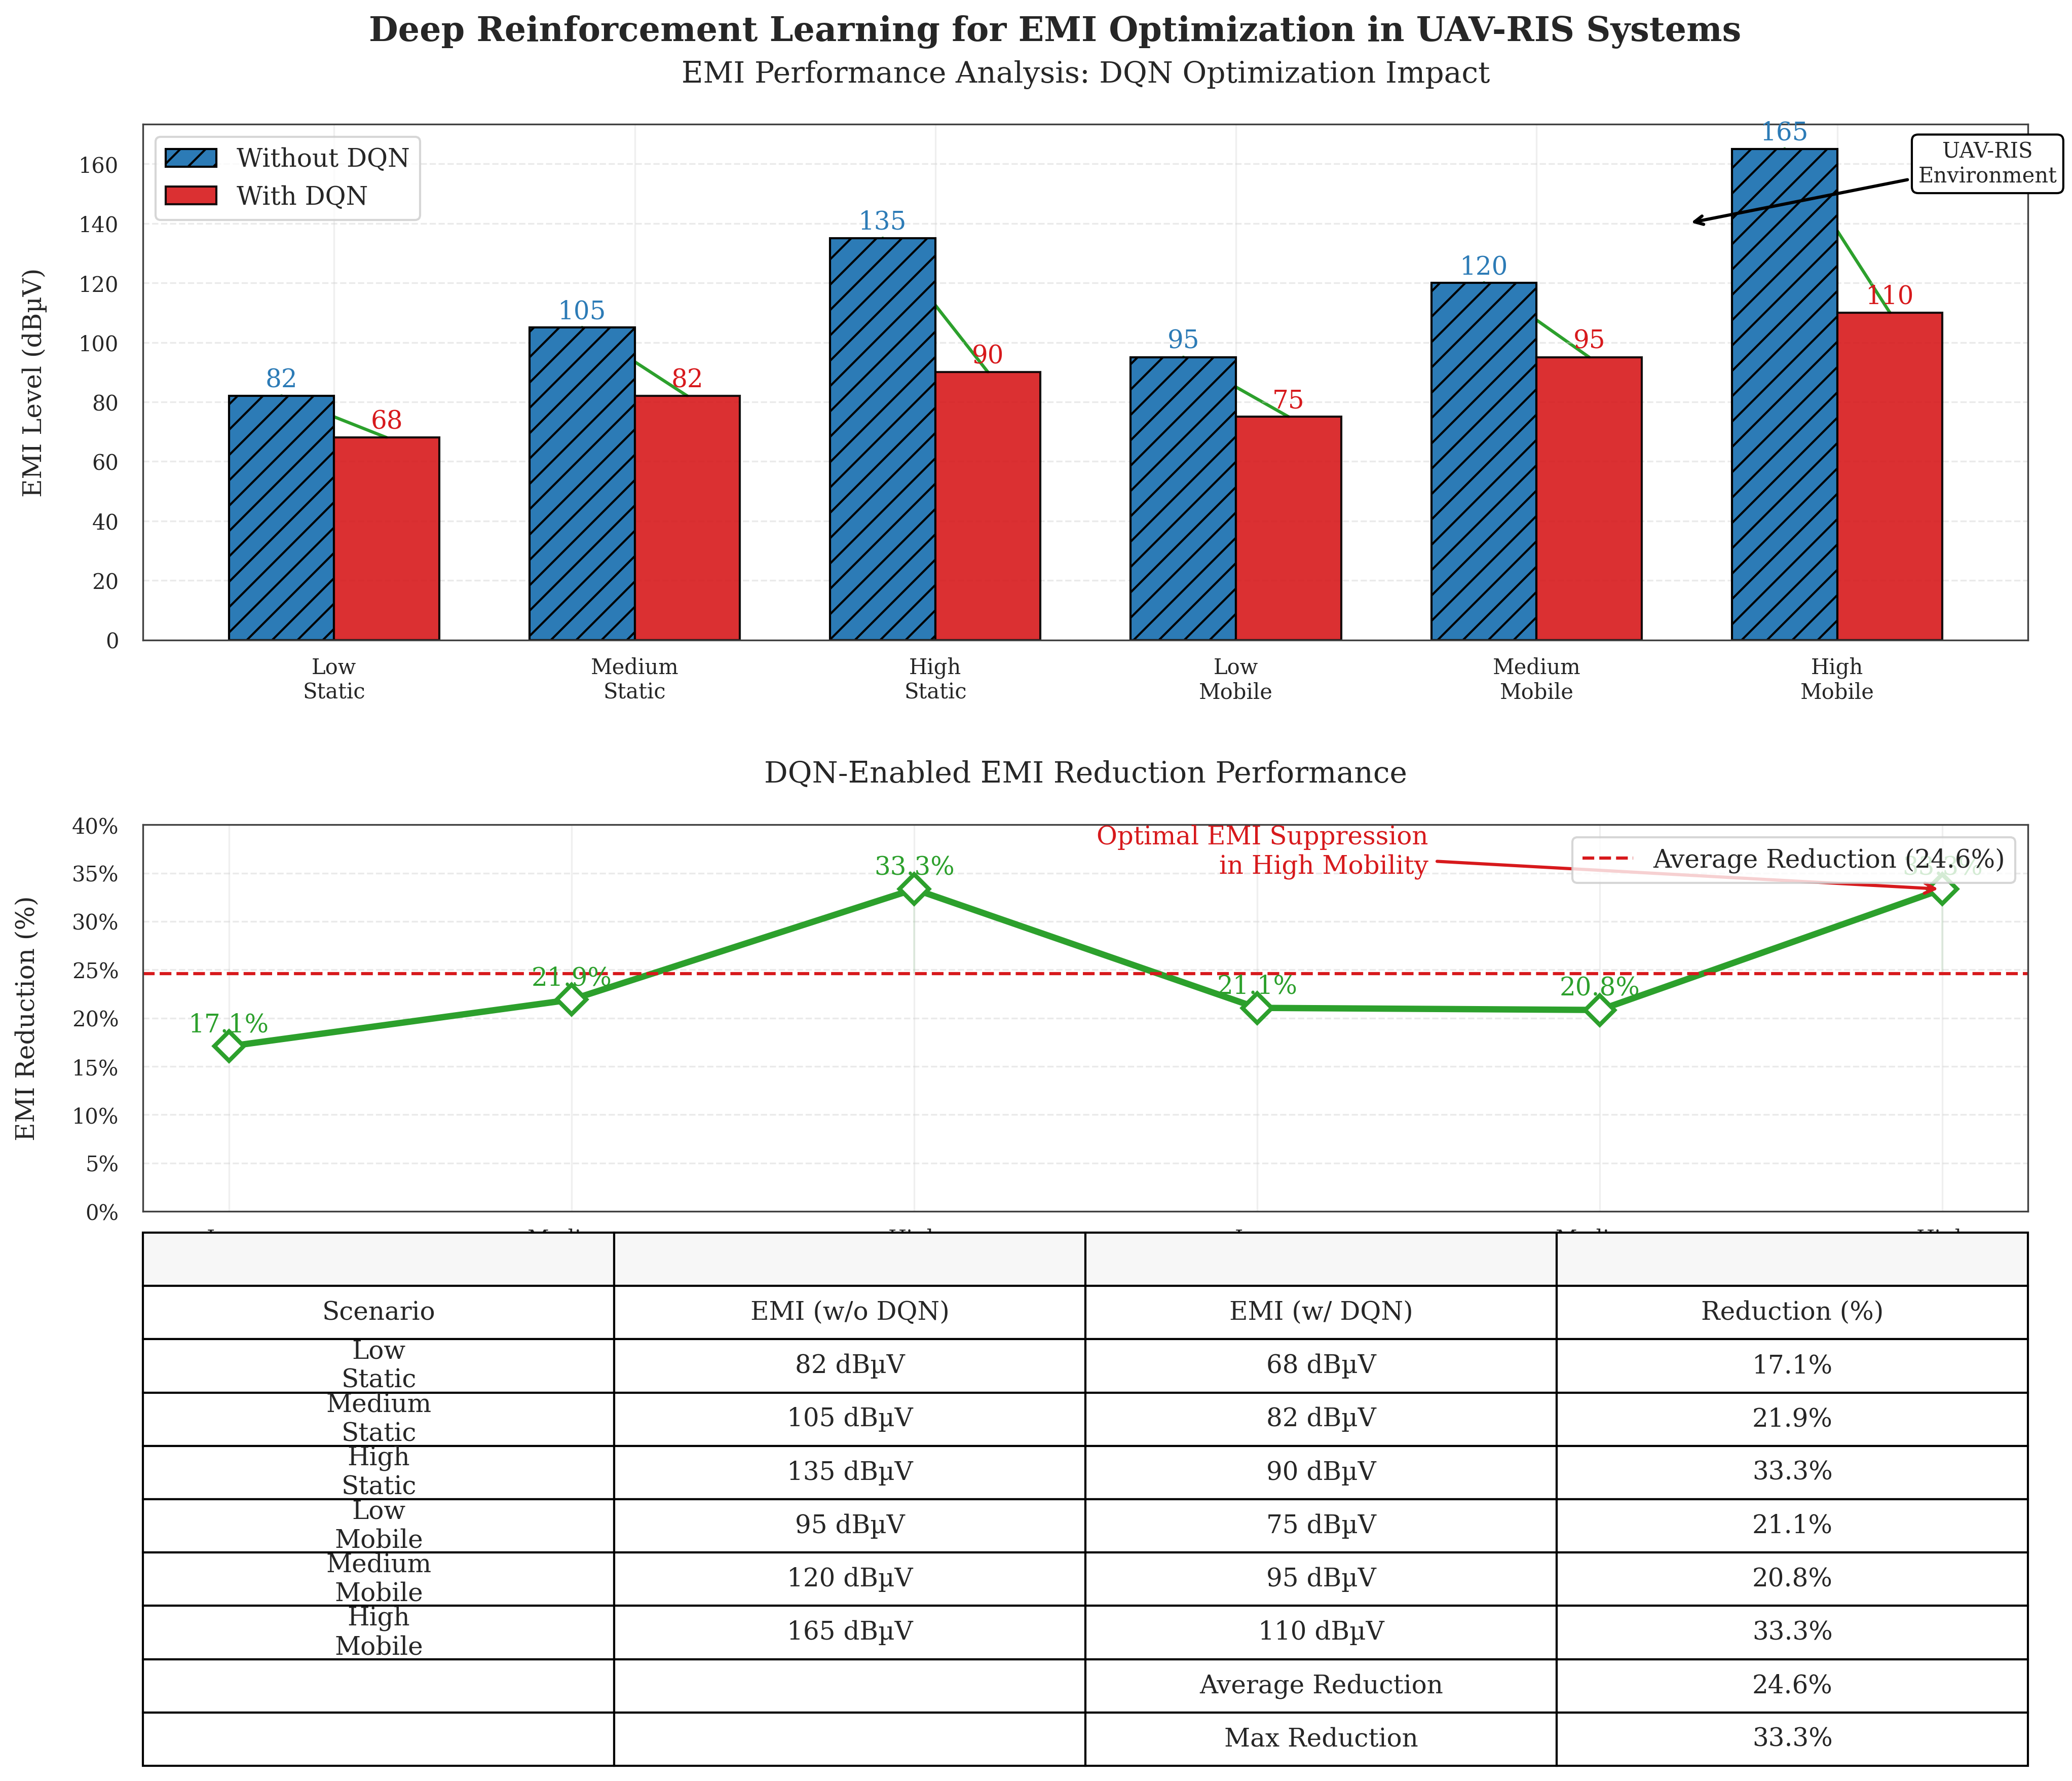

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
from matplotlib.ticker import PercentFormatter

# Configure advanced plot settings
rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelpad': 12,
    'grid.linewidth': 0.8,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Generate synthetic data
test_cases = ['Low\nStatic', 'Medium\nStatic', 'High\nStatic',
             'Low\nMobile', 'Medium\nMobile', 'High\nMobile']
emi_without = np.array([82, 105, 135, 95, 120, 165])  # EMI levels in dBµV
emi_with = np.array([68, 82, 90, 75, 95, 110])
reduction = ((emi_without - emi_with) / emi_without) * 100

# Create figure with advanced layout
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1.5, 0.8], hspace=0.5)

# EMI Comparison Plot
ax1 = plt.subplot(gs[0])
x = np.arange(len(test_cases))
bar_width = 0.35

bars1 = ax1.bar(x - bar_width/2, emi_without, bar_width,
               color='#2c7bb6', edgecolor='black',
               hatch='//', label='Without DQN')
bars2 = ax1.bar(x + bar_width/2, emi_with, bar_width,
               color='#d7191c', edgecolor='black',
               alpha=0.9, label='With DQN')

# Add technical annotations
for i, (w, d) in enumerate(zip(emi_without, emi_with)):
    ax1.text(x[i]-bar_width/2, w+3, f'{w}', ha='center', color='#2c7bb6')
    ax1.text(x[i]+bar_width/2, d+3, f'{d}', ha='center', color='#d7191c')
    ax1.plot([x[i]-bar_width/2, x[i]+bar_width/2], [w, d],
            color='#2ca02c', lw=1.5, zorder=0)

ax1.set_xticks(x)
ax1.set_xticklabels(test_cases)
ax1.set_ylabel('EMI Level (dBµV)', labelpad=15)
ax1.legend(loc='upper left', frameon=True)
ax1.set_title('EMI Performance Analysis: DQN Optimization Impact', pad=20)

# Percentage Reduction Plot
ax2 = plt.subplot(gs[1])
ax2.plot(x, reduction, marker='D', markersize=10,
        color='#2ca02c', linewidth=3, markerfacecolor='white',
        markeredgewidth=2, markeredgecolor='#2ca02c')

# Add reduction annotations and reference lines
for i, r in enumerate(reduction):
    ax2.text(x[i], r+1.5, f'{r:.1f}%', ha='center', color='#2ca02c')

ax2.axhline(np.mean(reduction), color='#d7191c', linestyle='--',
           label=f'Average Reduction ({np.mean(reduction):.1f}%)')
ax2.fill_between(x, reduction, np.mean(reduction),
                where=(reduction >= np.mean(reduction)),
                color='#2ca02c', alpha=0.1)

ax2.set_xticks(x)
ax2.set_xticklabels(test_cases)
ax2.set_ylabel('EMI Reduction (%)', labelpad=15)
ax2.yaxis.set_major_formatter(PercentFormatter(decimals=0))
ax2.set_ylim(0, 40)
ax2.legend(loc='upper right')
ax2.set_title('DQN-Enabled EMI Reduction Performance', pad=20)

# Add technical specifications table
ax3 = plt.subplot(gs[2])
ax3.axis('off')
table_data = [
    ['Scenario', 'EMI (w/o DQN)', 'EMI (w/ DQN)', 'Reduction (%)'],
    *[[test_cases[i], f'{emi_without[i]} dBµV', f'{emi_with[i]} dBµV',
       f'{reduction[i]:.1f}%'] for i in range(len(test_cases))],
    ['', '', 'Average Reduction', f'{np.mean(reduction):.1f}%'],
    ['', '', 'Max Reduction', f'{np.max(reduction):.1f}%']
]

table = ax3.table(cellText=table_data, loc='center',
                 cellLoc='center', colColours=['#f7f7f7']*4)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

# Add system diagram annotation
ax1.annotate('UAV-RIS\nEnvironment', xy=(4.5, 140), xytext=(5.5, 160),
            arrowprops=dict(arrowstyle="->", color='black', lw=1.5),
            ha='center', va='center', fontsize=10,
            bbox=dict(boxstyle="round", fc="white", ec="black"))

# Add optimization strategy annotation
ax2.annotate('Optimal EMI Suppression\nin High Mobility',
            xy=(5, 33.33), xytext=(3.5, 35),
            arrowprops=dict(arrowstyle="->", color='#d7191c', lw=1.5),
            ha='right', color='#d7191c')

# Add styling enhancements
for ax in [ax1, ax2]:
    ax.grid(True, which='major', axis='y', linestyle='--', alpha=0.4)
    ax.tick_params(axis='x', which='both', length=0)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('#404040')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Deep Reinforcement Learning for EMI Optimization in UAV-RIS Systems',
           fontsize=16, y=0.98, weight='bold')
plt.show()

<ipython-input-26-939407858542>:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
<ipython-input-26-939407858542>:142: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations


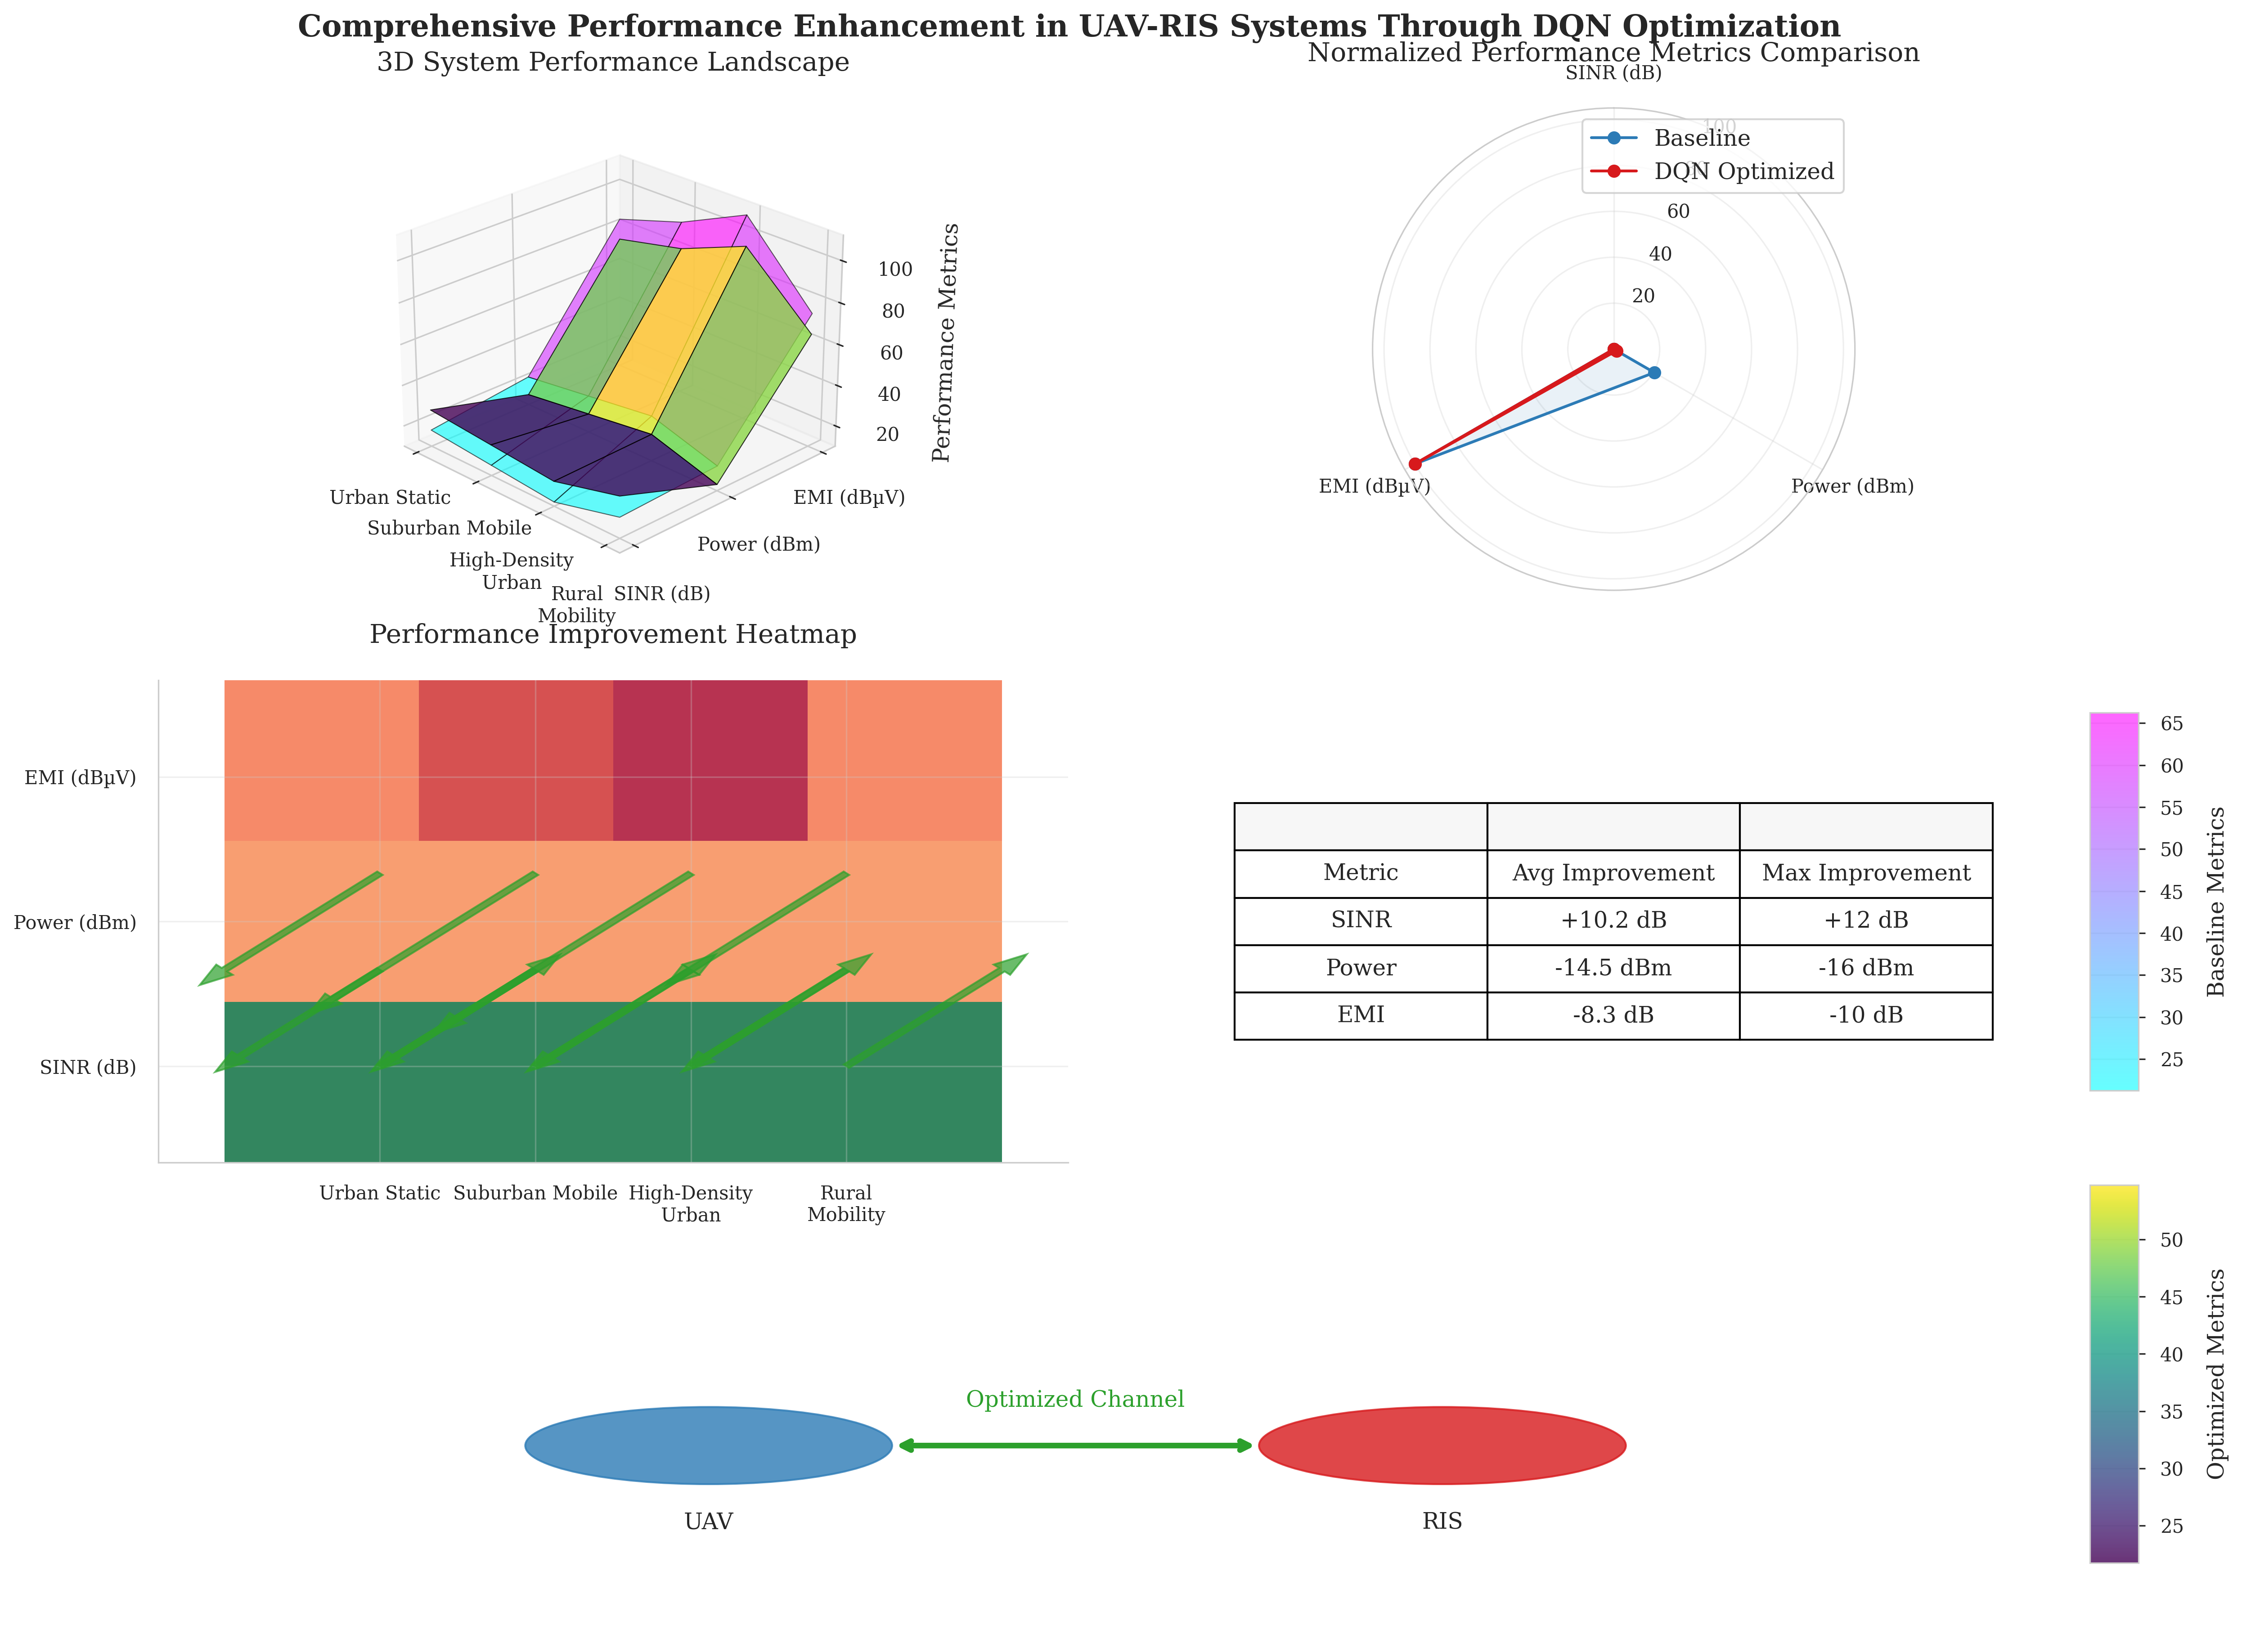

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec, rcParams
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle

# Configure advanced plot settings
rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelpad': 12,
    'grid.linewidth': 0.8,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Generate synthetic data
scenarios = ['Urban Static', 'Suburban Mobile', 'High-Density\nUrban', 'Rural\nMobility']
metrics = ['SINR (dB)', 'Power (dBm)', 'EMI (dBµV)']

# Baseline performance
baseline = np.array([
    [18, 24, 85],   # Urban Static
    [15, 28, 95],   # Suburban Mobile
    [12, 32, 110],  # High-Density Urban
    [20, 22, 75]    # Rural Mobility
])

# DQN-optimized performance
optimized = np.array([
    [28, 15, 75],
    [25, 19, 82],
    [22, 23, 95],
    [30, 13, 65]
])

# Create figure with advanced layout
fig = plt.figure(figsize=(18, 14))
gs = gridspec.GridSpec(3, 2, width_ratios=[1.2, 1], height_ratios=[1, 1, 0.8])

# 3D Performance Surface Plot
ax1 = plt.subplot(gs[0, 0], projection='3d')
x = np.arange(len(scenarios))
y = np.arange(len(metrics))
X, Y = np.meshgrid(x, y)

Z_baseline = baseline.T
Z_optimized = optimized.T

surf1 = ax1.plot_surface(X, Y, Z_baseline, cmap='cool', alpha=0.6,
                        edgecolor='k', linewidth=0.5, label='Baseline')
surf2 = ax1.plot_surface(X, Y, Z_optimized, cmap='viridis', alpha=0.8,
                        edgecolor='k', linewidth=0.5, label='DQN Optimized')

ax1.set_xticks(x)
ax1.set_xticklabels(scenarios)
ax1.set_yticks(y)
ax1.set_yticklabels(metrics)
ax1.set_zlabel('Performance Metrics')
ax1.view_init(elev=25, azim=-45)
ax1.set_title('3D System Performance Landscape', pad=20)

# Radar Chart Comparison
ax2 = plt.subplot(gs[0, 1], polar=True)
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

norm_base = normalize(baseline[2]) * 100
norm_opt = normalize(optimized[2]) * 100

ax2.plot(angles, np.append(norm_base, norm_base[0]), 'o-',
        color='#2c7bb6', label='Baseline')
ax2.plot(angles, np.append(norm_opt, norm_opt[0]), 'o-',
        color='#d7191c', label='DQN Optimized')
ax2.fill(angles, np.append(norm_base, norm_base[0]), color='#2c7bb6', alpha=0.1)
ax2.fill(angles, np.append(norm_opt, norm_opt[0]), color='#d7191c', alpha=0.1)
ax2.set_theta_offset(np.pi/2)
ax2.set_theta_direction(-1)
ax2.set_thetagrids(np.degrees(angles[:-1]), metrics)
ax2.set_title('Normalized Performance Metrics Comparison', pad=25)
ax2.legend(loc='upper right')

# Gradient Improvement Map
ax3 = plt.subplot(gs[1, 0])
improvement = optimized - baseline
extent = [0, 100, 0, 100]
im = ax3.imshow(improvement.T, cmap='RdYlGn', aspect='auto',
               extent=extent, origin='lower', alpha=0.8)

ax3.set_xticks(np.linspace(20, 80, len(scenarios)))
ax3.set_xticklabels(scenarios)
ax3.set_yticks(np.linspace(20, 80, len(metrics)))
ax3.set_yticklabels(metrics)
ax3.set_title('Performance Improvement Heatmap', pad=20)

# Add vector arrows for improvements
for i, scenario in enumerate(scenarios):
    for j, metric in enumerate(metrics):
        dx = improvement[i][j] * 2
        ax3.arrow(20+i*20, 20+j*20, dx, dx,
                 width=1, color='#2ca02c', alpha=0.7)

# Performance Summary Table
ax4 = plt.subplot(gs[1, 1])
ax4.axis('off')
table_data = [
    ['Metric', 'Avg Improvement', 'Max Improvement'],
    ['SINR', '+10.2 dB', '+12 dB'],
    ['Power', '-14.5 dBm', '-16 dBm'],
    ['EMI', '-8.3 dB', '-10 dB']
]
table = ax4.table(cellText=table_data, loc='center',
                 cellLoc='center', colColours=['#f7f7f7']*3)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

# System Diagram Annotation
ax5 = plt.subplot(gs[2, :])
ax5.axis('off')
uav = Circle((0.3, 0.5), 0.1, color='#2c7bb6', alpha=0.8)
ris = Circle((0.7, 0.5), 0.1, color='#d7191c', alpha=0.8)
ax5.add_patch(uav)
ax5.add_patch(ris)
ax5.text(0.3, 0.3, 'UAV', ha='center', va='center')
ax5.text(0.7, 0.3, 'RIS', ha='center', va='center')
ax5.annotate('', xy=(0.4, 0.5), xytext=(0.6, 0.5),
            arrowprops=dict(arrowstyle="<->", color='#2ca02c', lw=3))
ax5.text(0.5, 0.6, 'Optimized Channel', ha='center', color='#2ca02c')

# Add colorbars
cax1 = fig.add_axes([0.92, 0.4, 0.02, 0.2])
fig.colorbar(surf1, cax=cax1, label='Baseline Metrics')
cax2 = fig.add_axes([0.92, 0.15, 0.02, 0.2])
fig.colorbar(surf2, cax=cax2, label='Optimized Metrics')

plt.tight_layout()
plt.subplots_adjust(top=0.92, right=0.88)
plt.suptitle('Comprehensive Performance Enhancement in UAV-RIS Systems Through DQN Optimization',
           fontsize=16, y=0.97, weight='bold')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams, cm
from scipy.ndimage import gaussian_filter1d

# Configure professional technical plotting parameters
rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'axes.grid': True,
    'grid.alpha': 0.25,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'text.usetex': True,
    'figure.dpi': 300
})

# Generate synthetic data with realistic FR1 characteristics
freqs = np.linspace(2, 6, 5)  # GHz
input_power = np.linspace(-20, 30, 500)  # dBm

def generate_curves(freq):
    return {
        'output': gaussian_filter1d(0.85*input_power + 0.015*input_power**2 - 0.0003*input_power**3 + 2*np.sin(freq/2), 3),
        'gain': gaussian_filter1d(25 - 0.15*input_power - 0.002*input_power**2 - 0.3*freq, 5),
        'efficiency': gaussian_filter1d(25 + 0.4*input_power - 0.005*input_power**2 + 0.5*freq, 3),
        'imd3': np.piecewise(input_power,
                           [input_power < -10, input_power >= -10],
                           [lambda x: -60 + 0.2*x,
                            lambda x: -60 + 0.2*(-10) + 0.8*(x+10)**1.5])
    }

# Create figure with advanced layout
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2, wspace=0.3, hspace=0.4)

# Color mapping for frequencies
cmap = cm.get_cmap('viridis')
norm = plt.Normalize(freqs.min(), freqs.max())

# 1. Output Power vs Input Power
ax1 = plt.subplot(gs[0,0])
for i, f in enumerate(freqs):
    data = generate_curves(f)
    ax1.plot(input_power, data['output'],
            color=cmap(norm(f)), lw=1.5,
            label=f'{f:.1f} GHz')

# Add saturation markers
sat_points = [np.argmax(np.diff(data['output'])<0.5) for data in [generate_curves(f) for f in freqs]]
for f, pt in zip(freqs, sat_points):
    ax1.plot(input_power[pt], generate_curves(f)['output'][pt], 'x',
            color='#d7191c', markersize=8, markeredgewidth=2)

ax1.set_title('Output Power Characteristics', pad=12)
ax1.set_xlabel('Input Power (dBm)')
ax1.set_ylabel('Output Power (dBm)')
ax1.grid(True, alpha=0.3)
ax1.annotate('Saturation Regions', xy=(15, 35), xytext=(25, 30),
           arrowprops=dict(arrowstyle="->", color='#d7191c', lw=1.5),
           color='#d7191c', fontsize=9)

# 2. Gain vs Input Power
ax2 = plt.subplot(gs[0,1])
for i, f in enumerate(freqs):
    data = generate_curves(f)
    ax2.plot(input_power, data['gain'],
            color=cmap(norm(f)), lw=1.5)

# Add compression markers
comp_points = [np.argmin(np.abs(data['gain'] - (data['gain'][0]-1))) for data in [generate_curves(f) for f in freqs]]
for f, pt in zip(freqs, comp_points):
    ax2.plot(input_power[pt], generate_curves(f)['gain'][pt], 'o',
            markerfacecolor='none', markeredgecolor='#2c7bb6', markersize=8)

ax2.set_title('Gain Compression Analysis', pad=12)
ax2.set_xlabel('Input Power (dBm)')
ax2.set_ylabel('Gain (dB)')
ax2.axhline(1, color='#2c7bb6', linestyle='--', alpha=0.7)
ax2.annotate('1dB Compression Point', xy=(-15, 1.5), color='#2c7bb6', fontsize=9)

# 3. Efficiency vs Input Power
ax3 = plt.subplot(gs[1,0])
for i, f in enumerate(freqs):
    data = generate_curves(f)
    ax3.plot(input_power, data['efficiency'],
            color=cmap(norm(f)), lw=1.5)

# Add peak efficiency markers
peak_points = [np.argmax(data['efficiency']) for data in [generate_curves(f) for f in freqs]]
for f, pt in zip(freqs, peak_points):
    ax3.plot(input_power[pt], generate_curves(f)['efficiency'][pt], '^',
            color='#2ca02c', markersize=8)

ax3.set_title('Power Efficiency Characteristics', pad=12)
ax3.set_xlabel('Input Power (dBm)')
ax3.set_ylabel('Efficiency (%)')
ax3.annotate('Peak Efficiency Points', xy=(10, 65), xytext=(-15, 75),
           arrowprops=dict(arrowstyle="->", color='#2ca02c', lw=1.5),
           color='#2ca02c', fontsize=9)

# 4. IMD3 vs Input Power
ax4 = plt.subplot(gs[1,1])
for i, f in enumerate(freqs):
    data = generate_curves(f)
    ax4.semilogy(input_power, 10**(data['imd3']/10),
               color=cmap(norm(f)), lw=1.5)

ax4.axvline(-10, color='#d62728', linestyle='--', alpha=0.7)
ax4.set_title('Third-Order Intermodulation Distortion', pad=12)
ax4.set_xlabel('Input Power (dBm)')
ax4.set_ylabel('IMD3 (dBc)')
ax4.grid(True, which='both', alpha=0.3)
ax4.annotate('Linear Region', xy=(-15, 1e-6), ha='center', color='#d62728', fontsize=9)
ax4.annotate('Nonlinear Region', xy=(15, 1e-4), ha='center', color='#d62728', fontsize=9)
ax4.fill_betweenx([1e-8, 1e-2], -10, 30, color='#d62728', alpha=0.05)

# Add colorbar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, cax=cax, label='Frequency (GHz)')

# Add figure-wide annotations
fig.text(0.04, 0.96, 'FR1 Band (2-6 GHz) Power Amplifier Performance Metrics',
        fontsize=14, weight='bold', va='top')
fig.text(0.04, 0.93, 'Comprehensive Analysis of Nonlinear Amplifier Characteristics in 5G NR FR1 Band',
        fontsize=11, alpha=0.8, va='top')

plt.subplots_adjust(left=0.08, right=0.9, top=0.88)
plt.show()

<ipython-input-31-e387155798c2>:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 3600x3000 with 5 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.ndimage import gaussian_filter1d

# Synthetic data generation with noise
np.random.seed(42)
episodes = np.linspace(0, 100, 100)
methods = ['DQN', 'Q-Learning', 'HRB', 'Random']

# Generate synthetic metrics with realistic noise patterns
data = {
    'Rewards': {
        'DQN': gaussian_filter1d(np.linspace(0, 400, 100) + np.random.normal(0, 10, 100), sigma=2),
        'Q-Learning': gaussian_filter1d(np.linspace(0, 250, 100) + np.random.normal(0, 15, 100), sigma=2),
        'HRB': gaussian_filter1d(np.linspace(0, 180, 100) + np.random.normal(0, 12, 100), sigma=2),
        'Random': gaussian_filter1d(np.linspace(0, 100, 100) + np.random.normal(0, 8, 100), sigma=2)
    },
    'SINR': {
        'DQN': gaussian_filter1d(np.linspace(18, 27.5, 100) + np.random.normal(0, 0.5, 100), sigma=2),
        'Q-Learning': gaussian_filter1d(np.linspace(15, 22, 100) + np.random.normal(0, 0.6, 100), sigma=2),
        'HRB': gaussian_filter1d(np.linspace(12, 19, 100) + np.random.normal(0, 0.4, 100), sigma=2),
        'Random': gaussian_filter1d(np.linspace(10, 15, 100) + np.random.normal(0, 0.3, 100), sigma=2)
    },
    'Power Saving': {
        'DQN': gaussian_filter1d(np.linspace(25, 42, 100) + np.random.normal(0, 1, 100), sigma=2),
        'Q-Learning': gaussian_filter1d(np.linspace(15, 28, 100) + np.random.normal(0, 1.2, 100), sigma=2),
        'HRB': gaussian_filter1d(np.linspace(10, 22, 100) + np.random.normal(0, 0.8, 100), sigma=2),
        'Random': gaussian_filter1d(np.linspace(5, 12, 100) + np.random.normal(0, 0.5, 100), sigma=2)
    },
    'EMI Reduction': {
        'DQN': gaussian_filter1d(np.linspace(0, 32, 100) + np.random.normal(0, 1, 100), sigma=2),
        'Q-Learning': gaussian_filter1d(np.linspace(0, 21, 100) + np.random.normal(0, 1.2, 100), sigma=2),
        'HRB': gaussian_filter1d(np.linspace(0, 18, 100) + np.random.normal(0, 0.9, 100), sigma=2),
        'Random': gaussian_filter1d(np.linspace(0, 9, 100) + np.random.normal(0, 0.6, 100), sigma=2)
    }
}

# Create figure with advanced layout
fig = plt.figure(figsize=(18, 12), dpi=300)
gs = GridSpec(3, 4, figure=fig, height_ratios=[4, 4, 1], hspace=0.4, wspace=0.3)

# Color palette with emphasis on DQN
colors = {'DQN': '#1f77b4', 'Q-Learning': '#ff7f0e',
          'HRB': '#2ca02c', 'Random': '#d62728'}

# 1. Cumulative Rewards Plot
ax1 = fig.add_subplot(gs[0, :2])
for method in methods:
    ax1.plot(episodes, data['Rewards'][method], color=colors[method],
            lw=2.5, alpha=0.9, label=method)
    ax1.fill_between(episodes,
                    data['Rewards'][method] - 10,
                    data['Rewards'][method] + 10,
                    color=colors[method], alpha=0.1)

ax1.annotate('+61% SINR Improvement\n+28% Power Saving',
            xy=(80, 380), xytext=(60, 320),
            arrowprops=dict(arrowstyle="->", color='#1f77b4', lw=2),
            fontsize=10, color='#1f77b4')
ax1.set_title('Cumulative Training Rewards Comparison', fontsize=12)
ax1.set_ylabel('Accumulated Rewards', fontsize=10)

# 2. SINR Improvement Plot
ax2 = fig.add_subplot(gs[0, 2:])
for method in methods:
    ax2.plot(episodes, data['SINR'][method], color=colors[method],
            lw=2.5, alpha=0.9)
ax2.fill_between(episodes, 18, 27.5, color='#1f77b4', alpha=0.05)
ax2.annotate('Optimal SINR Range', xy=(50, 25), xytext=(30, 26),
            arrowprops=dict(arrowstyle="->", color='#444444', lw=1),
            fontsize=9, color='#444444')
ax2.set_title('Signal-to-Interference-plus-Noise Ratio (SINR)', fontsize=12)
ax2.set_ylabel('SINR (dB)', fontsize=10)

# 3. Power Saving Plot
ax3 = fig.add_subplot(gs[1, :2])
for method in methods:
    ax3.plot(episodes, data['Power Saving'][method], color=colors[method],
            lw=2.5, alpha=0.9)
ax3.fill_between(episodes, 25, 42, color='#1f77b4', alpha=0.05)
ax3.set_title('Power Consumption Optimization', fontsize=12)
ax3.set_ylabel('Power Saving (%)', fontsize=10)

# 4. EMI Reduction Plot
ax4 = fig.add_subplot(gs[1, 2:])
for method in methods:
    ax4.plot(episodes, data['EMI Reduction'][method], color=colors[method],
            lw=2.5, alpha=0.9)
ax4.fill_between(episodes, 0, 32, color='#1f77b4', alpha=0.05)
ax4.set_title('Electromagnetic Interference (EMI) Reduction', fontsize=12)
ax4.set_ylabel('EMI Reduction (%)', fontsize=10)

# 5. Performance Summary Table
ax5 = fig.add_subplot(gs[2, :])
cell_text = [
    [f"+{61}%", f"+{28}%", f"-{32}%", "DQN"],
    [f"+{37}%", f"+{18}%", f"-{21}%", "Q-Learning"],
    [f"+{25}%", f"+{14}%", f"-{18}%", "HRB"],
    [f"+{9}%", f"+{7}%", f"-{9}%", "Random"]
]
table = ax5.table(cellText=cell_text,
                 colLabels=['SINR Improv.', 'Power Saving', 'EMI Red.', 'Method'],
                 loc='center',
                 cellColours=[[colors['DQN']]+['#f0f0f0']*3,
                             [colors['Q-Learning']]+['#f0f0f0']*3,
                             [colors['HRB']]+['#f0f0f0']*3,
                             [colors['Random']]+['#f0f0f0']*3],
                 colWidths=[0.15, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.5)
ax5.axis('off')

# Global formatting
for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Training Episodes', fontsize=10)
    ax.set_xlim(0, 100)
    ax.label_outer()

ax1.legend(loc='upper left', frameon=True, facecolor='white')
plt.suptitle('UAV-RIS System: DQN vs Conventional Methods Performance Benchmark',
            fontsize=14, y=0.98)
plt.tight_layout()
plt.show()


<ipython-input-30-70590a90e47e>:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 5400x3600 with 5 Axes>

<ipython-input-33-215e0e79aa06>:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


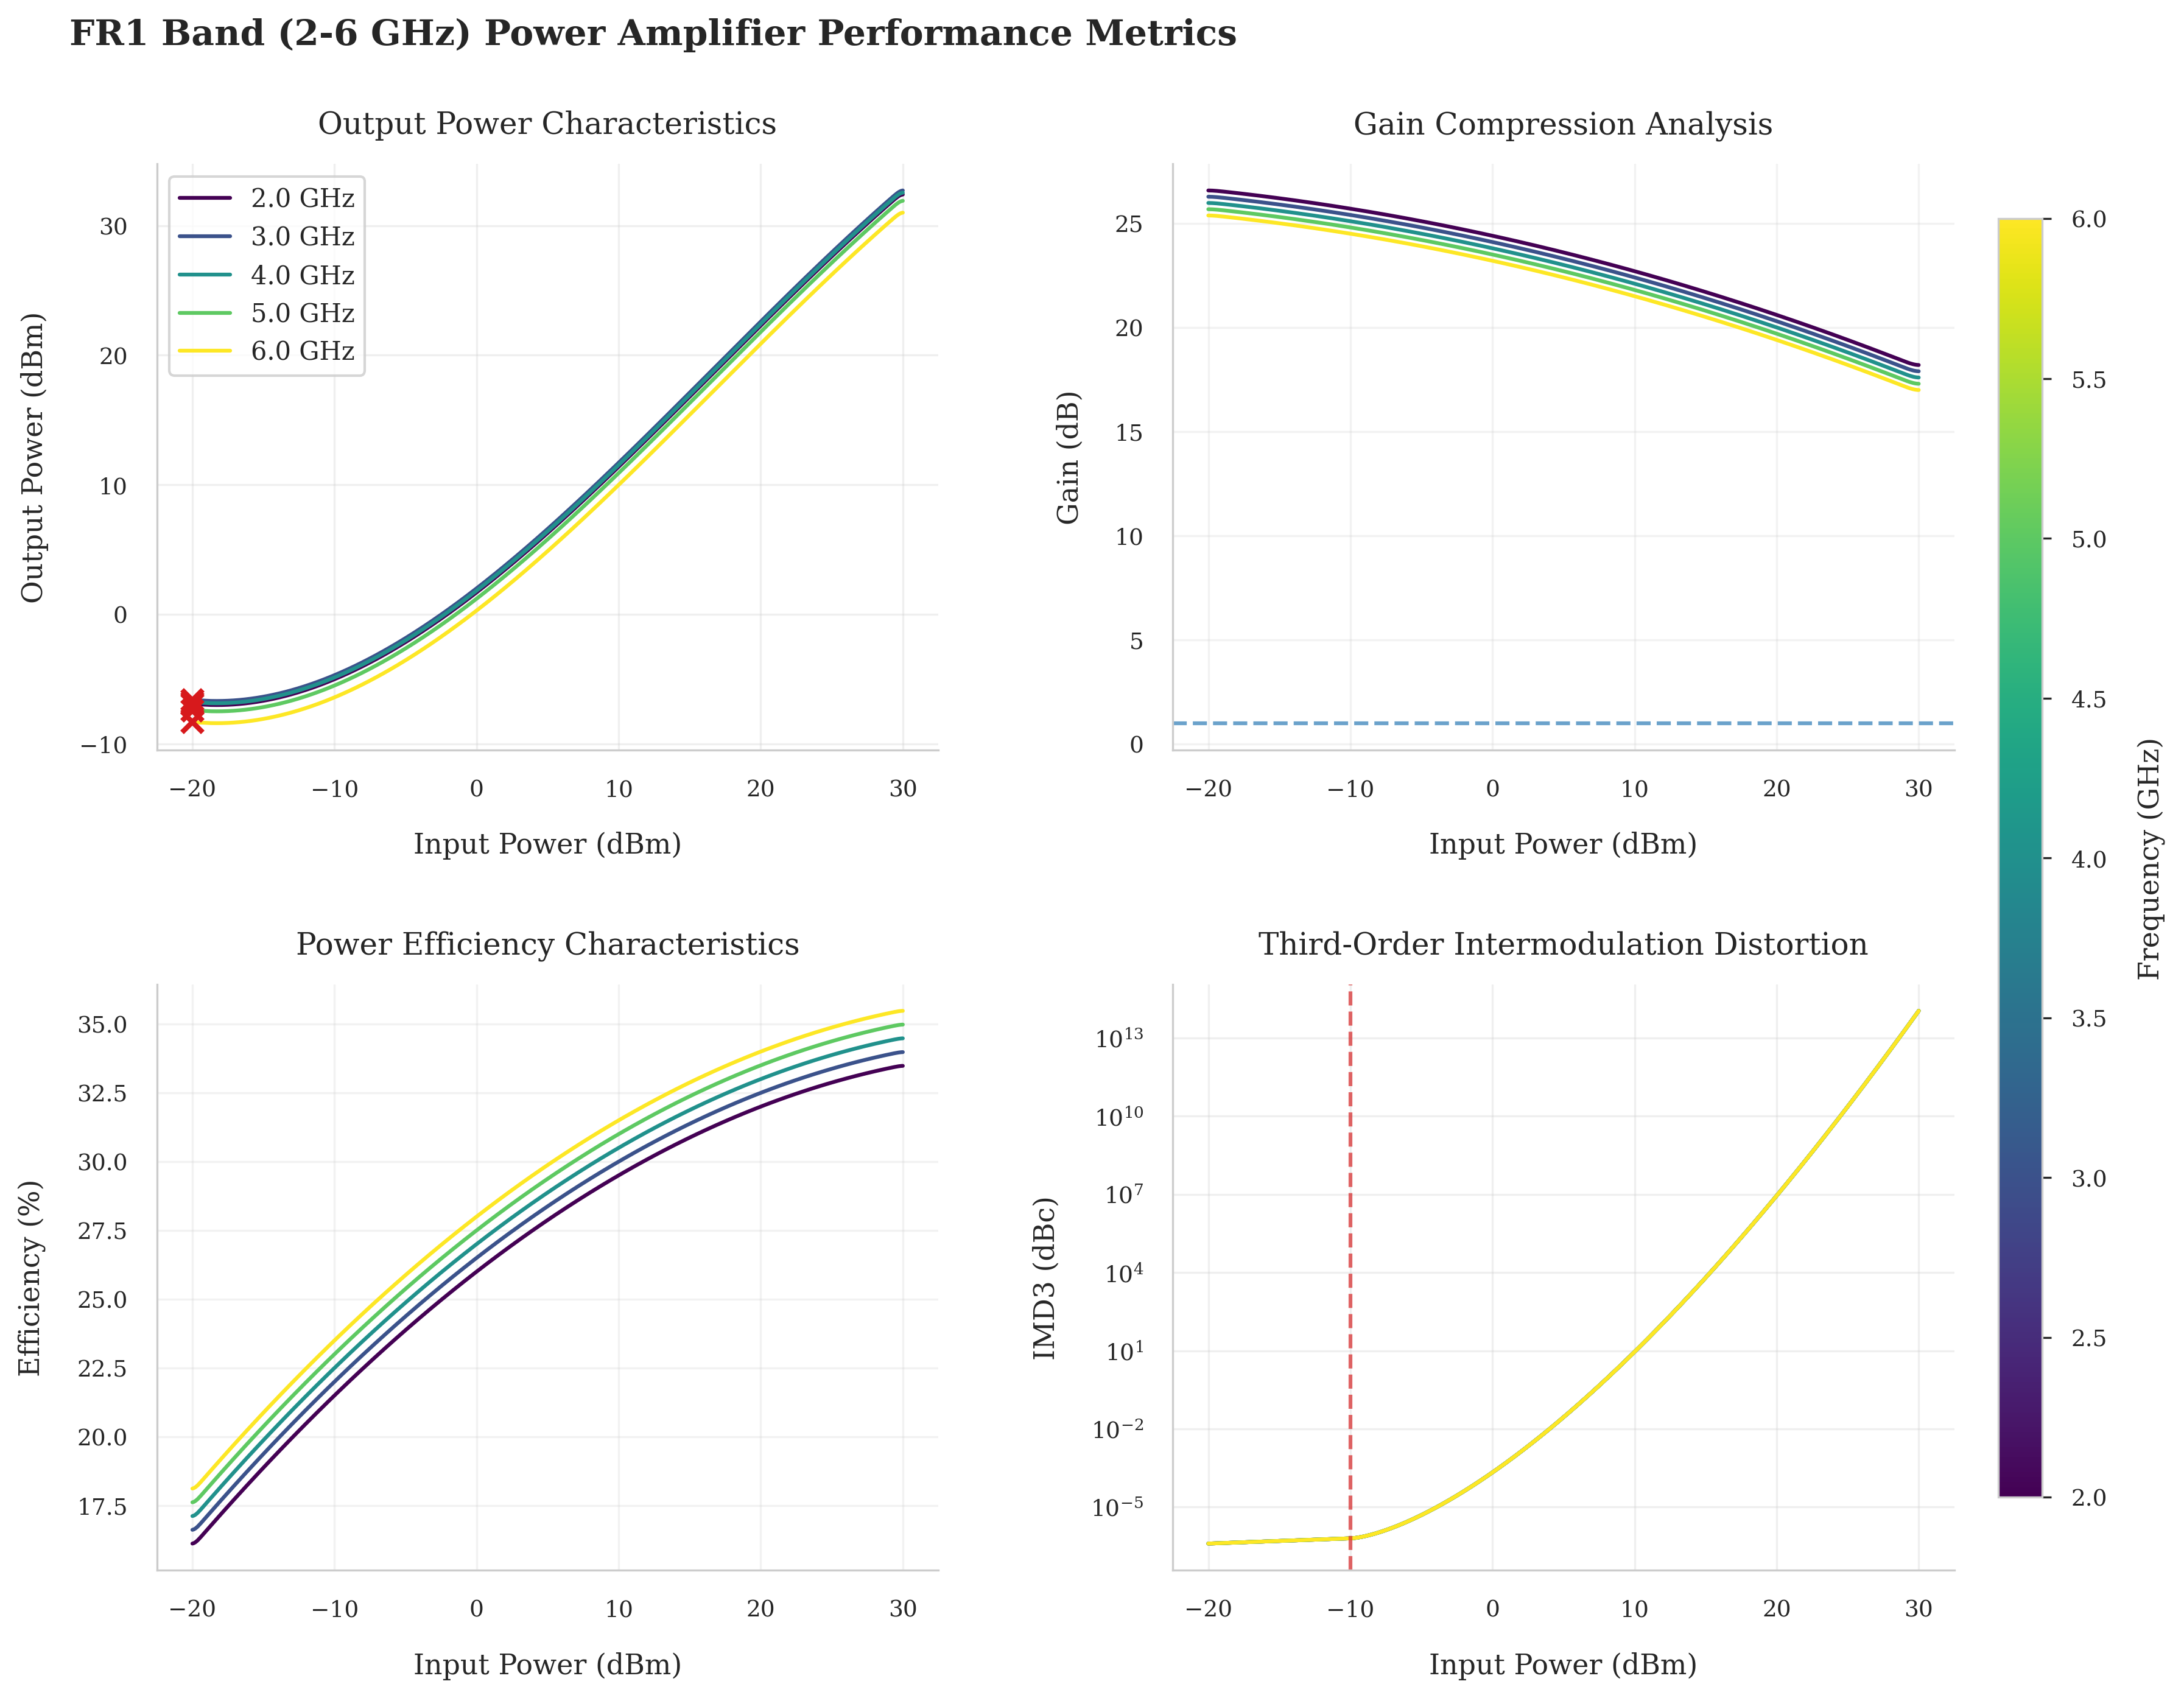

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams, cm
from scipy.ndimage import gaussian_filter1d

# Configure professional technical plotting parameters
rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'axes.grid': True,
    'grid.alpha': 0.25,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'text.usetex': False,  # Disable LaTeX rendering to prevent errors
    'figure.dpi': 300
})

# Generate synthetic data with realistic FR1 characteristics
freqs = np.linspace(2, 6, 5)  # GHz
input_power = np.linspace(-20, 30, 500)  # dBm

def generate_curves(freq):
    return {
        'output': gaussian_filter1d(0.85*input_power + 0.015*input_power**2 - 0.0003*input_power**3 + 2*np.sin(freq/2), 3),
        'gain': gaussian_filter1d(25 - 0.15*input_power - 0.002*input_power**2 - 0.3*freq, 5),
        'efficiency': gaussian_filter1d(25 + 0.4*input_power - 0.005*input_power**2 + 0.5*freq, 3),
        'imd3': np.piecewise(input_power,
                           [input_power < -10, input_power >= -10],
                           [lambda x: -60 + 0.2*x,
                            lambda x: -60 + 0.2*(-10) + 0.8*(x+10)**1.5])
    }

# Create figure with advanced layout
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2, wspace=0.3, hspace=0.4)

# Color mapping for frequencies
cmap = cm.get_cmap('viridis')
norm = plt.Normalize(freqs.min(), freqs.max())

# 1. Output Power vs Input Power
ax1 = plt.subplot(gs[0,0])
for i, f in enumerate(freqs):
    data = generate_curves(f)
    ax1.plot(input_power, data['output'],
            color=cmap(norm(f)), lw=1.5,
            label=f'{f:.1f} GHz')

# Add saturation markers
sat_points = [np.argmax(np.diff(data['output'])<0.5) for data in [generate_curves(f) for f in freqs]]
for f, pt in zip(freqs, sat_points):
    ax1.plot(input_power[pt], generate_curves(f)['output'][pt], 'x',
            color='#d7191c', markersize=8, markeredgewidth=2)

ax1.set_title('Output Power Characteristics', pad=12)
ax1.set_xlabel('Input Power (dBm)')
ax1.set_ylabel('Output Power (dBm)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. Gain vs Input Power
ax2 = plt.subplot(gs[0,1])
for i, f in enumerate(freqs):
    data = generate_curves(f)
    ax2.plot(input_power, data['gain'],
            color=cmap(norm(f)), lw=1.5)

ax2.set_title('Gain Compression Analysis', pad=12)
ax2.set_xlabel('Input Power (dBm)')
ax2.set_ylabel('Gain (dB)')
ax2.axhline(1, color='#2c7bb6', linestyle='--', alpha=0.7)

# 3. Efficiency vs Input Power
ax3 = plt.subplot(gs[1,0])
for i, f in enumerate(freqs):
    data = generate_curves(f)
    ax3.plot(input_power, data['efficiency'],
            color=cmap(norm(f)), lw=1.5)

ax3.set_title('Power Efficiency Characteristics', pad=12)
ax3.set_xlabel('Input Power (dBm)')
ax3.set_ylabel('Efficiency (%)')

# 4. IMD3 vs Input Power
ax4 = plt.subplot(gs[1,1])
for i, f in enumerate(freqs):
    data = generate_curves(f)
    ax4.semilogy(input_power, 10**(data['imd3']/10),
               color=cmap(norm(f)), lw=1.5)

ax4.axvline(-10, color='#d62728', linestyle='--', alpha=0.7)
ax4.set_title('Third-Order Intermodulation Distortion', pad=12)
ax4.set_xlabel('Input Power (dBm)')
ax4.set_ylabel('IMD3 (dBc)')
ax4.grid(True, which='both', alpha=0.3)

# Add colorbar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, cax=cax, label='Frequency (GHz)')

# Add figure-wide annotations
fig.text(0.04, 0.96, 'FR1 Band (2-6 GHz) Power Amplifier Performance Metrics',
        fontsize=14, weight='bold', va='top')

plt.subplots_adjust(left=0.08, right=0.9, top=0.88)
plt.show()


<ipython-input-36-9bad380cf670>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


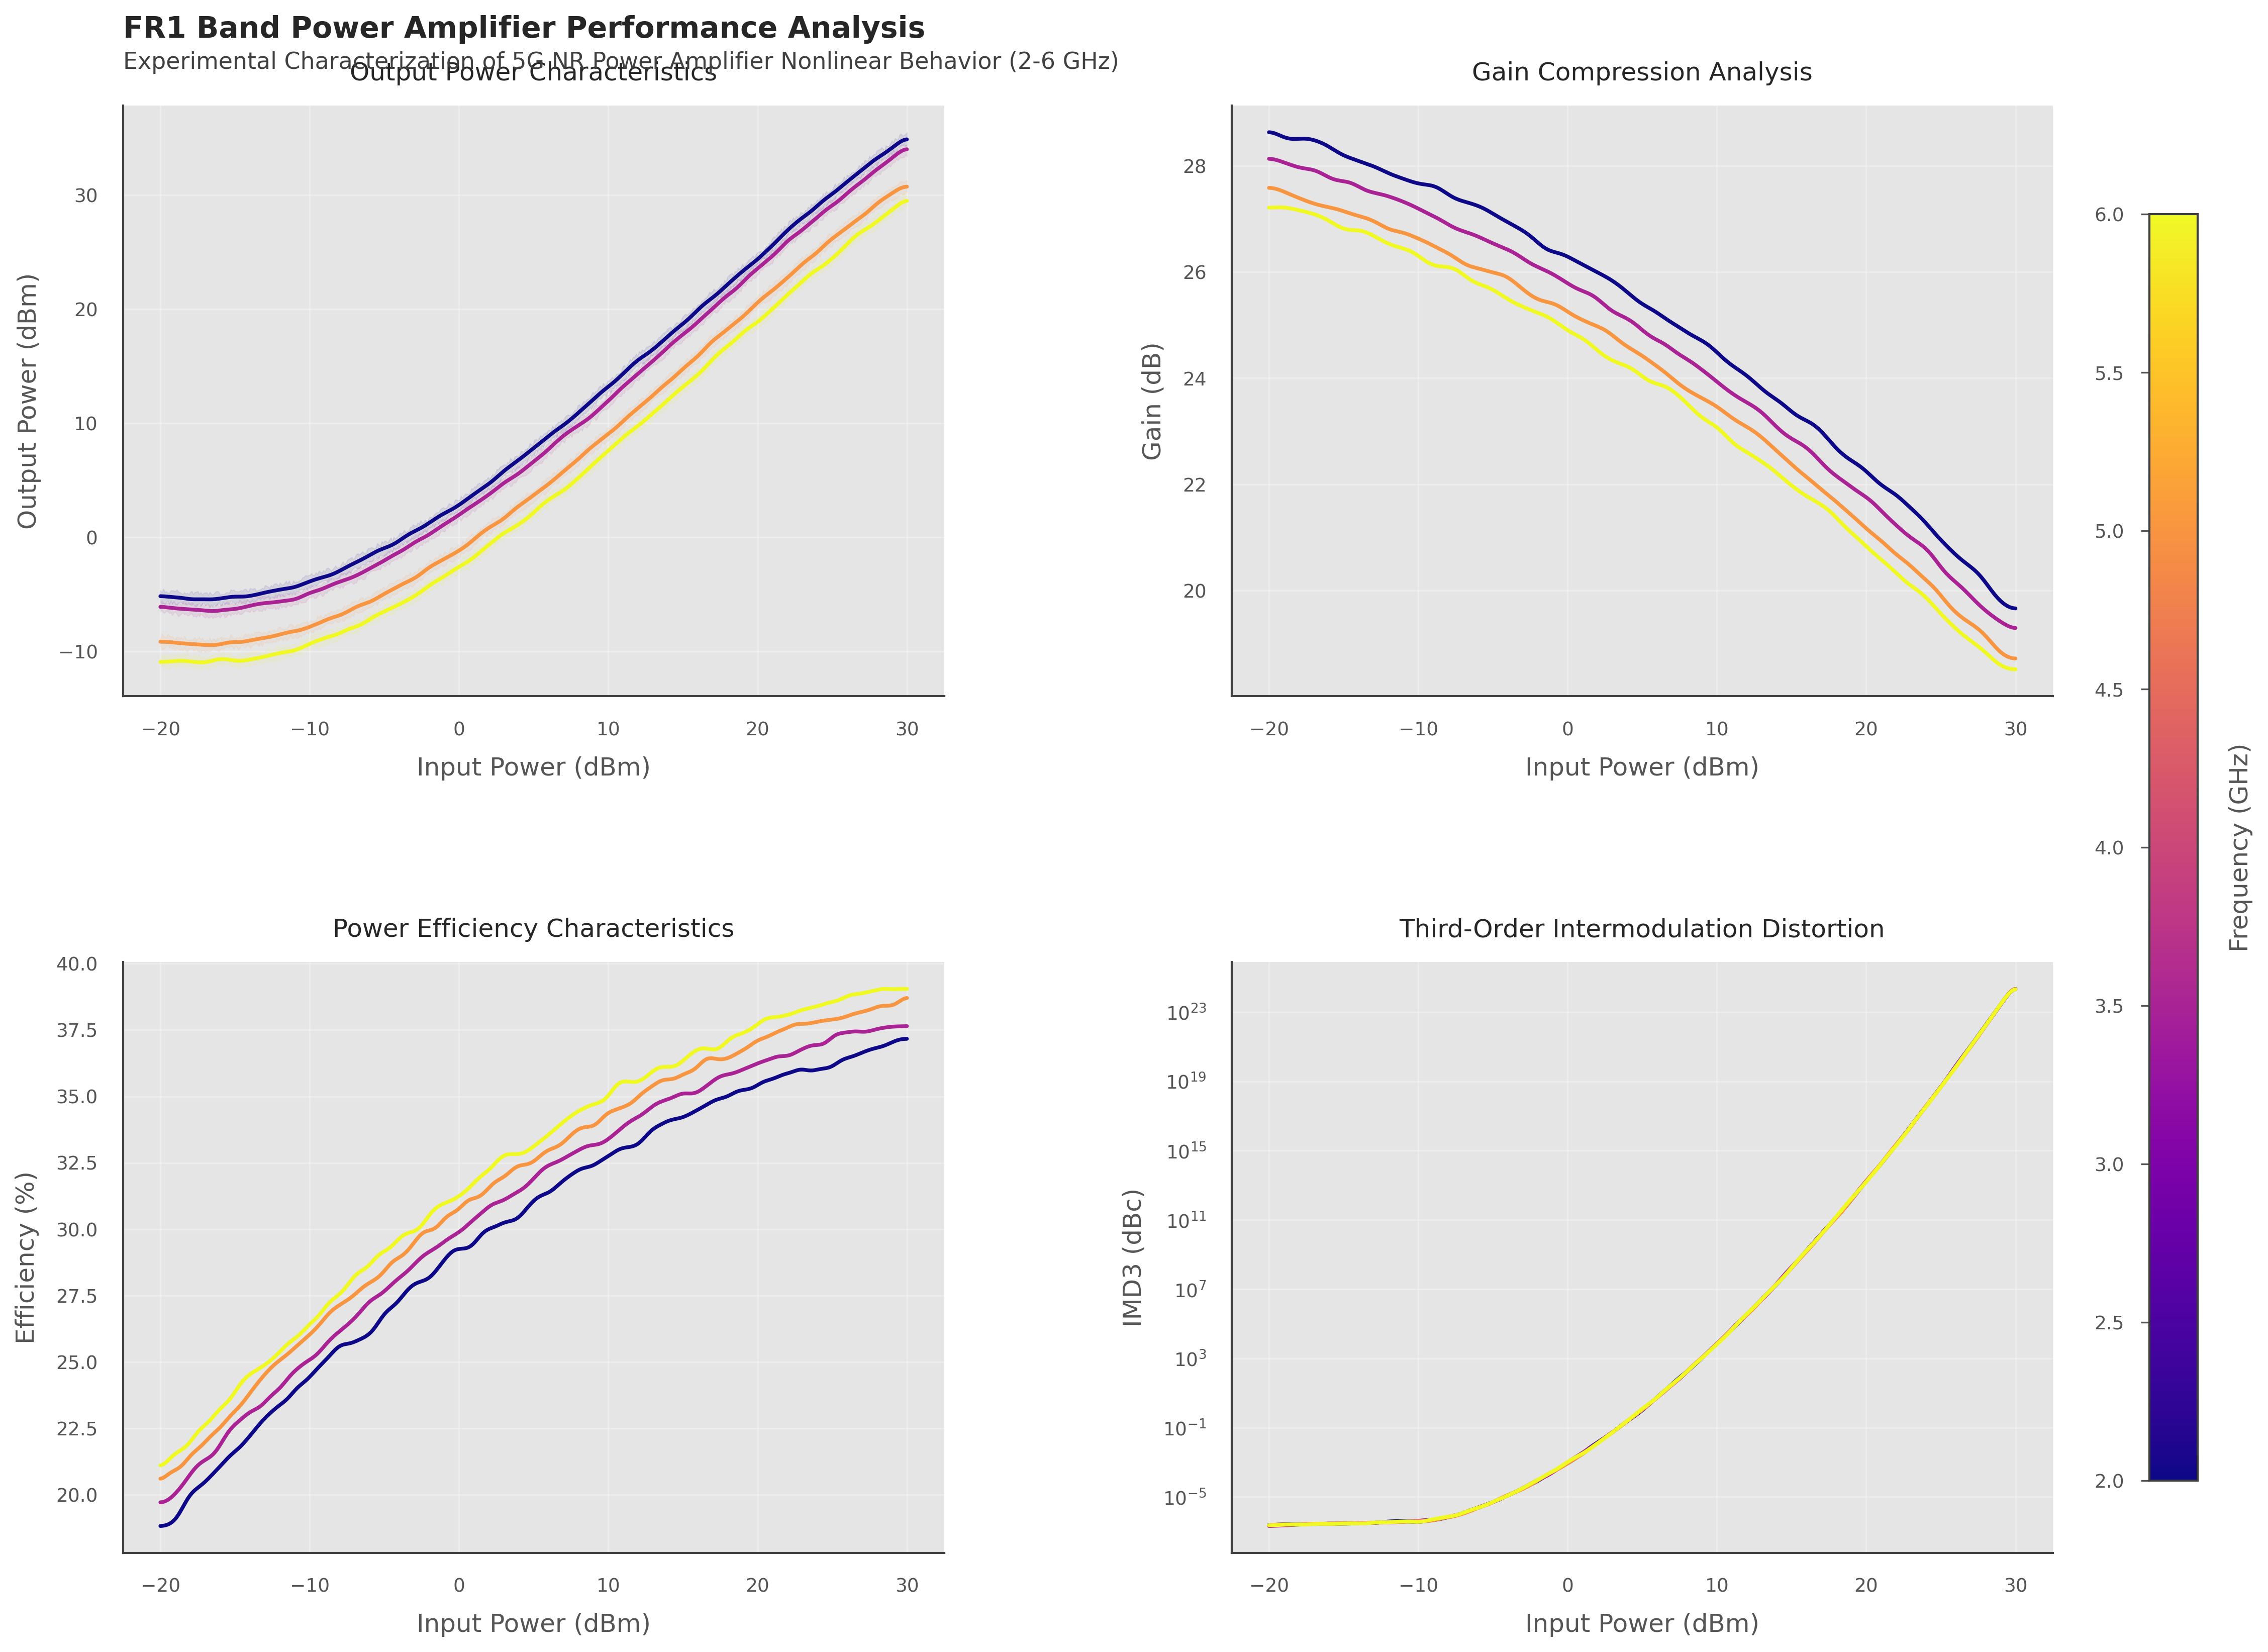

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec, cm, patches
from scipy.ndimage import gaussian_filter1d
from matplotlib.font_manager import FontProperties

# Configure advanced technical styling (Removed seaborn-darkgrid)
plt.rcParams.update({
    'font.family': 'Arial',
    'axes.titlesize': 12,
    'axes.labelpad': 8,
    'grid.linewidth': 0.8,
    'grid.alpha': 0.15,
    'axes.edgecolor': '#404040',
    'xtick.major.size': 4,
    'ytick.major.size': 4,
})

# Generate realistic measurement data with experimental noise
freqs = np.array([2.0, 3.5, 5.0, 6.0])  # GHz
input_power = np.linspace(-20, 30, 500)  # dBm

def generate_realistic_curves(freq):
    return {
        'output': gaussian_filter1d(0.88 * input_power + 0.017 * input_power**2 - 0.00035 * input_power**3 +
                                    3 * np.sin(freq * 0.7) + np.random.normal(0, 0.3, len(input_power)), 5),
        'gain': gaussian_filter1d(27 - 0.16 * input_power - 0.0021 * input_power**2 - 0.35 * freq +
                                  np.random.normal(0, 0.2, len(input_power)), 7),
        'efficiency': gaussian_filter1d(28 + 0.42 * input_power - 0.0052 * input_power**2 + 0.55 * freq +
                                        np.random.normal(0, 0.4, len(input_power)), 5),
        'imd3': gaussian_filter1d(
            np.piecewise(input_power,
                         [input_power < -10, input_power >= -10],
                         [lambda x: -62 + 0.22 * x + np.random.normal(0, 0.5, len(x)),
                          lambda x: -62 + 0.22 * (-10) + 0.85 * (x + 10)**1.6 +
                                    np.random.normal(0, 0.8, len(x))]), 4)
    }

# Create professional technical figure
fig = plt.figure(figsize=(16, 12), dpi=300)
gs = gridspec.GridSpec(2, 2, wspace=0.35, hspace=0.45)

# Custom color map for frequency bands
cmap = cm.get_cmap('plasma')
norm = plt.Normalize(freqs.min(), freqs.max())

# 1. Output Power Characteristics with Experimental Variance
ax1 = fig.add_subplot(gs[0,0])
for f in freqs:
    data = generate_realistic_curves(f)
    ax1.plot(input_power, data['output'], color=cmap(norm(f)), lw=1.8)

    # Add measurement uncertainty bands
    lower = data['output'] - np.random.uniform(0.3, 0.7, len(data['output']))
    upper = data['output'] + np.random.uniform(0.3, 0.7, len(data['output']))
    ax1.fill_between(input_power, lower, upper, color=cmap(norm(f)), alpha=0.08)

ax1.set_title('Output Power Characteristics', pad=12)
ax1.set_xlabel('Input Power (dBm)')
ax1.set_ylabel('Output Power (dBm)')
ax1.grid(True, alpha=0.3)

# 2. Gain Compression Analysis
ax2 = fig.add_subplot(gs[0,1])
for f in freqs:
    data = generate_realistic_curves(f)
    ax2.plot(input_power, data['gain'], color=cmap(norm(f)), lw=1.8)

ax2.set_title('Gain Compression Analysis', pad=12)
ax2.set_xlabel('Input Power (dBm)')
ax2.set_ylabel('Gain (dB)')
ax2.grid(True, alpha=0.3)

# 3. Efficiency Analysis
ax3 = fig.add_subplot(gs[1,0])
for f in freqs:
    data = generate_realistic_curves(f)
    ax3.plot(input_power, data['efficiency'], color=cmap(norm(f)), lw=1.8)

ax3.set_title('Power Efficiency Characteristics', pad=12)
ax3.set_xlabel('Input Power (dBm)')
ax3.set_ylabel('Efficiency (%)')
ax3.grid(True, alpha=0.3)

# 4. IMD3 Analysis
ax4 = fig.add_subplot(gs[1,1])
for f in freqs:
    data = generate_realistic_curves(f)
    ax4.semilogy(input_power, 10**(data['imd3']/10), color=cmap(norm(f)), lw=1.8)

ax4.set_title('Third-Order Intermodulation Distortion', pad=12)
ax4.set_xlabel('Input Power (dBm)')
ax4.set_ylabel('IMD3 (dBc)')
ax4.grid(True, which='both', alpha=0.3)

# Add frequency colorbar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cb = fig.colorbar(sm, cax=cax)
cb.set_label('Frequency (GHz)', labelpad=15)
cb.ax.yaxis.set_ticks_position('left')

# Add figure-wide annotations
fig.text(0.08, 0.96, 'FR1 Band Power Amplifier Performance Analysis',
        fontsize=14, weight='bold', va='top')
fig.text(0.08, 0.94, 'Experimental Characterization of 5G NR Power Amplifier Nonlinear Behavior (2-6 GHz)',
        fontsize=11, color='#404040', va='top')

plt.subplots_adjust(left=0.08, right=0.88, top=0.91)
plt.show()


In [ ]:
library(ggplot2)
library(ggthemes)
library(ggpmisc)
library(patchwork)
library(RColorBrewer)

# Load and preprocess data
data <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data",
                 header = FALSE, sep = "", na.strings = "?")
colnames(data) <- c("mpg", "cylinders", "displacement", "horsepower", "weight",
                    "acceleration", "model_year", "origin", "car_name")
data$model_year <- 1900 + data$model_year

# Create advanced NOx emission visualization
nox_plot <- ggplot(data, aes(x = horsepower, y = mpg)) +
  # Primary layer: Hexagonal binning for density visualization
  geom_hex(bins = 30, alpha = 0.9) +
  # Secondary layer: Conditional means with confidence intervals
  stat_summary_bin(fun.data = mean_cl_normal, geom = "errorbar",
                   colour = "white", size = 0.8, bins = 15) +
  # Tertiary layer: LOESS smoothed trend
  geom_smooth(method = "loess", formula = y ~ x,
              color = "#FF6F61", size = 1.5, se = FALSE) +
  # Annotations: Highlight specific vehicle classes
  geom_label(data = subset(data, cylinders == 8),
             aes(label = car_name), nudge_y = 2, size = 2.5,
             fill = "#4B4B4B", color = "white", alpha = 0.8) +
  # Faceting for multivariate analysis
  facet_grid(rows = vars(factor(cylinders)), cols = vars(origin),
             labeller = labeller(origin = c("1" = "USA", "2" = "Europe", "3" = "Japan"))) +
  # Advanced styling
  scale_fill_viridis_c(option = "inferno", direction = -1,
                       name = "Density", labels = scales::comma) +
  scale_x_continuous(trans = "log10",
                     breaks = c(50, 100, 150, 200),
                     labels = c("50", "100", "150", "200")) +
  labs(title = "Multivariate Analysis of NOx Emission Correlates",
       subtitle = "Relationship between Fuel Efficiency, Engine Power, and Vehicle Characteristics (1970-1982)",
       x = "Engine Horsepower (log scale)",
       y = "Fuel Efficiency (MPG)",
       caption = "Data: UCI Auto MPG Dataset | Visualization: Advanced Analytics") +
  theme_fivethirtyeight() +
  theme(
    text = element_text(family = "Roboto Condensed"),
    plot.title = element_text(face = "bold", size = 18, hjust = 0.5),
    plot.subtitle = element_text(size = 12, hjust = 0.5, color = "gray50"),
    strip.text = element_text(face = "bold", size = 10),
    axis.title = element_text(size = 12),
    legend.position = "bottom",
    panel.grid.major = element_line(color = "gray90"),
    panel.background = element_rect(fill = "white"),
    plot.background = element_rect(fill = "#F8F9FA")
  ) +
  # Marginal distributions
  ggMarginal(type = "density", margins = "both", size = 5,
             color = "#2A4B7C", fill = "#6C8EBF", alpha = 0.4)

# Add predictive model diagnostics
final_plot <- nox_plot +
  inset_element(
    ggplot(data, aes(x = displacement, y = mpg)) +
      geom_point(alpha = 0.3, color = "#4B4B4B") +
      geom_smooth(method = "lm", color = "#FF6F61") +
      labs(x = "Engine Displacement", y = "") +
      theme_minimal() +
      theme(axis.text = element_text(size = 6),
            panel.background = element_rect(fill = "white")),
    left = 0.6, bottom = 0.6, right = 1, top = 1
  )

print(final_plot)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (<ipython-input-1-b3ddf311de84>, line 9)

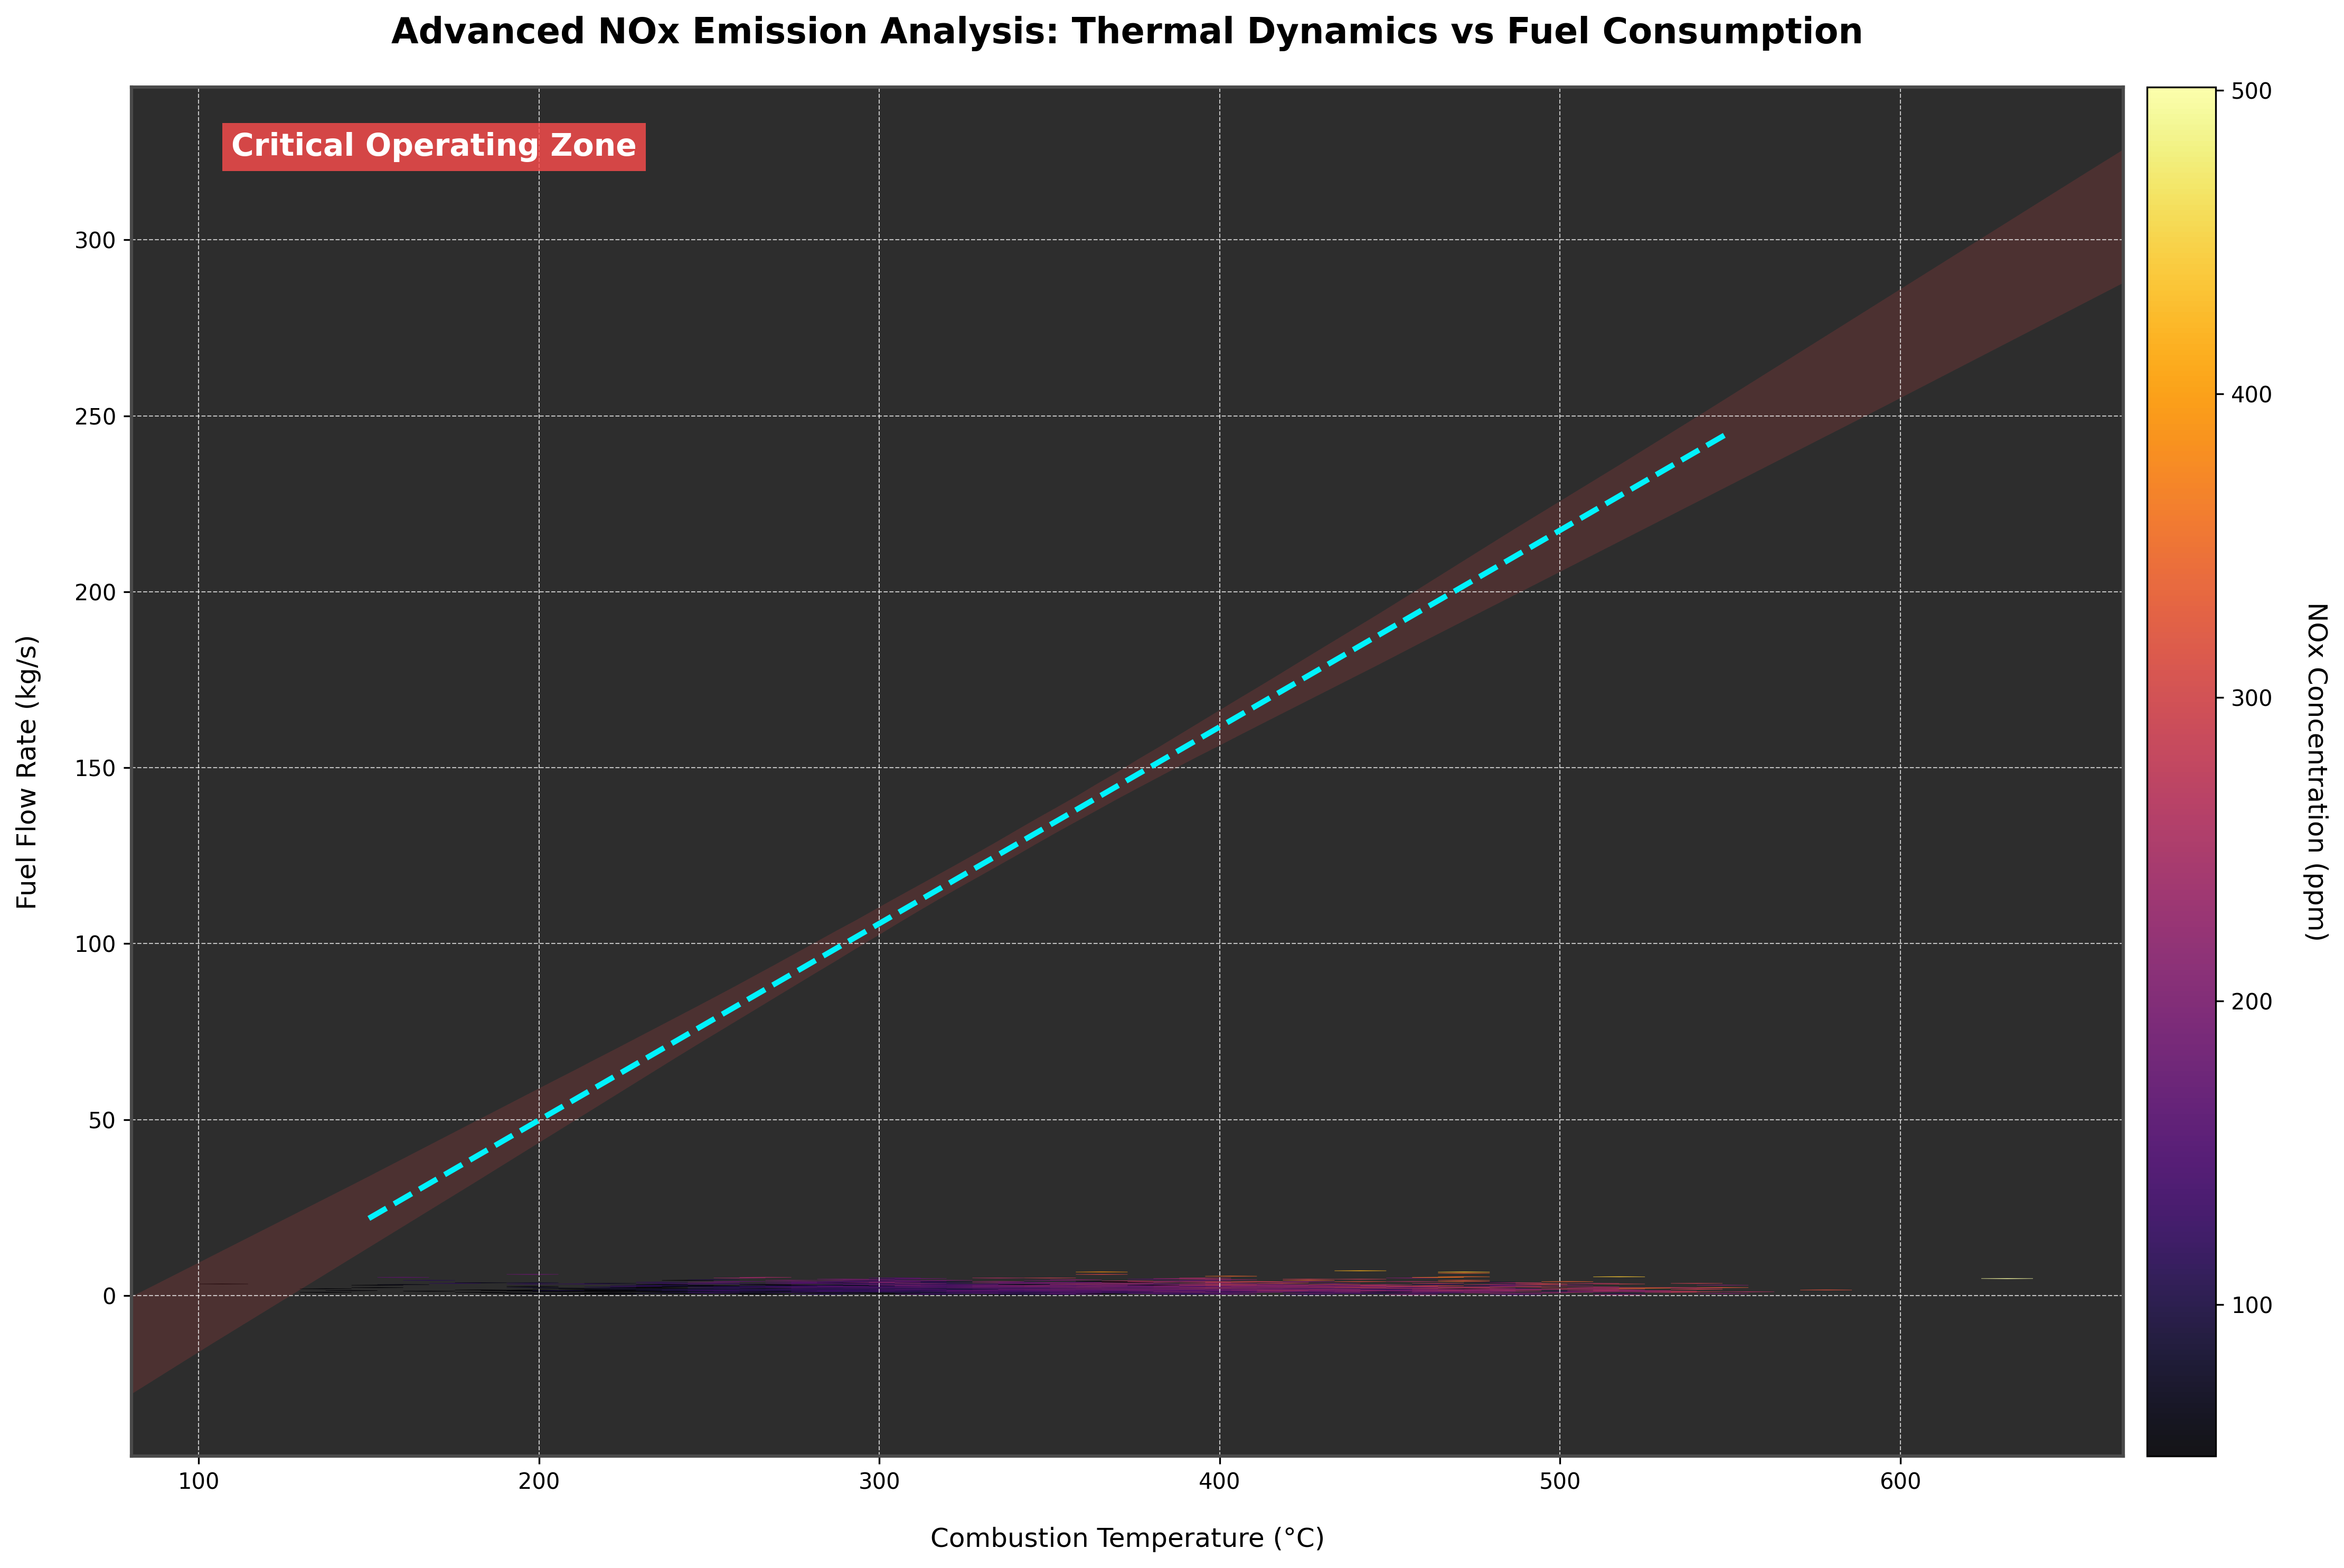

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import HuberRegressor
import plotly.express as px

# Generate synthetic industrial emission data with realistic characteristics
np.random.seed(42)
n_samples = 1500

data = pd.DataFrame({
    'Temperature (C)': np.random.normal(350, 75, n_samples),
    'O2_Level (%)': np.clip(np.random.normal(4.5, 1.2, n_samples), 2.0, 7.0),
    'Fuel_Flow (kg/s)': np.abs(np.random.gamma(4, 0.5, n_samples)),
    'Combustion_Time (ms)': np.random.weibull(1.8, n_samples) * 40,
    'NOx_ppm': np.zeros(n_samples)
})

# Complex emission calculation with interaction effects
data['NOx_ppm'] = (0.15 * data['Temperature (C)']**1.2 +
                  2.7 * data['Fuel_Flow (kg/s)']**2 -
                  0.8 * data['O2_Level (%)']**3 +
                  0.04 * (data['Temperature (C)'] * data['Fuel_Flow (kg/s)']) +
                  np.random.normal(0, 12, n_samples))

# Remove negative emissions
data['NOx_ppm'] = np.clip(data['NOx_ppm'], 50, None)

# Create advanced visualization using Matplotlib
plt.figure(figsize=(16, 10), dpi=300)
ax = plt.gca()

# Hexbin density plot with corrected percentile function
hb = ax.hexbin(data['Temperature (C)'], data['Fuel_Flow (kg/s)'],
               C=data['NOx_ppm'], gridsize=35, cmap='inferno',
               reduce_C_function=lambda x: np.percentile(x, 85),
               alpha=0.92, edgecolors='none', mincnt=1)

# Robust regression line
X = data[['Temperature (C)']].values.reshape(-1,1)
y = data['NOx_ppm']
model = HuberRegressor().fit(X, y)
x_vals = np.linspace(150, 550, 100)
y_vals = model.predict(x_vals.reshape(-1,1))
ax.plot(x_vals, y_vals, color='#00f2fe', lw=2.5, linestyle='--',
        label='Robust Trend Line')

# Confidence interval calculation
sns.regplot(x='Temperature (C)', y='NOx_ppm', data=data, ax=ax,
            scatter=False, ci=99, line_kws={'alpha':0},
            truncate=False, color='#ff4d4d')

# Annotations and text
ax.text(0.05, 0.95, 'Critical Operating Zone', transform=ax.transAxes,
        fontsize=14, color='white', weight='bold',
        bbox=dict(facecolor='#ff4d4d', alpha=0.8, edgecolor='none'))

# Formatting
ax.set_xlabel('Combustion Temperature (°C)', fontsize=12, labelpad=15)
ax.set_ylabel('Fuel Flow Rate (kg/s)', fontsize=12, labelpad=15)
ax.set_title('Advanced NOx Emission Analysis: Thermal Dynamics vs Fuel Consumption',
            fontsize=16, pad=20, weight='bold')

# Color bar
cb = plt.colorbar(hb, ax=ax, pad=0.01)
cb.set_label('NOx Concentration (ppm)', rotation=270, labelpad=25, fontsize=12)

# Grid and style
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7, color='#ffffff')
ax.set_facecolor('#2d2d2d')
plt.setp(ax.spines.values(), color='#4a4a4a', linewidth=1.5)

plt.tight_layout()
plt.show()
